# NFL Awards Prediction
Evan Stowell and Jacob Namath

We are trying to determine the recipients of the National Football League’s most coveted individual awards, given by the Associated Press. The Most Valuable Player (MVP), Offensive Player of The Year (OPOY), Defensive Player of The Year (DPOY), Offensive Rookie of The Year (OROY), and the Defensive Rookie of The Year (DROY). These awards are often very difficult to predict because of many different factors. Coaching, scheme, other players on the team. This is a problem because many people like to waste money gambling on these awards throughout the season. Our approach is going to be trying to find the best model that takes in information from past years to predict this year's award recipients, based on halfway through the season statistics. This is related to other work in the area because sports analytics is exploding right now. Teams and media companies have data analytics departments who want to predict the best of the best each year. Teams will try to predict how likely a catch is to be completed, average yards over expected, probability of scoring, and many other events and outcomes.

Specifically, we are interested in discovering to what extent certain statistics contribute to the number of award votes a player receives. And with this, we hope to create models capable of predicting how many votes any given player will receive. Our inputs will slightly differ depending on the award winner we are predicting and the position of the player in contention. For quarterbacks (QBs), we will mainly consider QB specific stats such as pass completion rate, yards gained by passing, passing touchdowns, and rushing touchdowns. For offensive non-QB players, namely wide receivers (WRs), running backs (RBs), and tight ends (TEs), we will consider passing/rushing yards, passing/rushing yards, and receptions/rushing attempts. For defensive players, we will consider relevant statistics such as tackles, sacks, and interceptions. Finally, with rookie voting, we will consider both offensive and defensive statistics, as well as time played as a measure of how important they are to the team. For all awards, we will also factor the team which they play to determine if a team’s quality affects an individual player’s standing in the voting.

This problem interests us because awards build a player’s legacy and are viewed as proof of greatness. However, it is very unlikely to attain unanimous agreement for which player was the greatest in any given season due to biases and media narratives. The most objective truth one can rely on for these debates are statistics. We hope that the results of our analysis will show how much statistics contribute to a player’s case for an award and how the differences between our expectations and reality reflect on inherent biases in football.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We are using the football database called Pro Football Reference. Every player who received a vote appears in the tables and their basic statistics relevant to their position are displayed. We took data from the 5 big player awards and added in statistics from each year to try to go beyond the basic statistics that were included.

# Loading in Data

In [3]:
data_path = '/content/drive/MyDrive/CS3540/FinalProject/'
# Load all 5 datasets
try:
    mvp_df = pd.read_csv(data_path + 'mvp_df_final_clean.csv')
    opoy_df = pd.read_csv(data_path + 'opoy_df_final_clean.csv')
    dpoy_df = pd.read_csv(data_path + 'dpoy_df_final_clean.csv')
    oroy_df = pd.read_csv(data_path + 'oroy_df_final_clean.csv')
    droy_df = pd.read_csv(data_path + 'droy_df_final_clean.csv')

    print("\n✓ All datasets loaded successfully\n")

    # Display dataset information
    datasets = {
        'MVP': mvp_df,
        'OPOY': opoy_df,
        'DPOY': dpoy_df,
        'OROY': oroy_df,
        'DROY': droy_df
    }

    print("Dataset Summary:")
    print("-" * 60)
    for name, df in datasets.items():
        print(f"{name:6} | Rows: {len(df):4} | Columns: {len(df.columns):2}")
    print("-" * 60)

except FileNotFoundError as e:
    print(f"\nError: Could not find one or more CSV files.")
    print(f"Please ensure all files are uploaded to Colab:")
    print("mvp_df_final_clean.csv")
    print("opoy_df_final_clean.csv")
    print("dpoy_df_final_clean.csv")
    print("oroy_df_final_clean.csv")
    print("droy_df_final_clean.csv")
    raise


✓ All datasets loaded successfully

Dataset Summary:
------------------------------------------------------------
MVP    | Rows:  228 | Columns: 53
OPOY   | Rows:  277 | Columns: 71
DPOY   | Rows:  331 | Columns: 22
OROY   | Rows:  185 | Columns: 21
DROY   | Rows:  229 | Columns: 16
------------------------------------------------------------


In [4]:
def display_dataset_info(df, award_name):
    """Display information about a dataset"""
    print(f"\n{award_name} Dataset Analysis")
    print("-" * 60)
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"\nColumn Names:\n{list(df.columns)}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    print(f"\nFirst 5 rows:")
    display(df.head())
    print(f"\nBasic Statistics:")
    display(df.describe())
    print("\n" + "-" * 60)

# Display information for each dataset
for name, df in datasets.items():
    display_dataset_info(df, name)



MVP Dataset Analysis
------------------------------------------------------------
Shape: 228 rows × 53 columns

Column Names:
['Unnamed: 0', 'Year', 'Rank', 'Player', 'Votes', 'Games', 'Games_Started', 'Age', 'Pass_QBrec', 'Pass_Rate', 'Pass_QBR', 'Pass_Y_per_A', 'Pass_AY_per_A', 'Pass_Y_per_C', 'Pass_Y_per_G', 'Pass_NY_per_A', 'Pass_ANY_per_A', 'Pass_Sk', 'Pass_4QC', 'Pass_GWD', 'Pass_Completions', 'Pass_Attempts', 'Pass_Yards', 'Pass_Touchdowns', 'Pass_Interceptions', 'Rush_Attempts', 'Rush_Yards', 'Rush_Touchdowns', 'Scrim_Receiving_Tgt', 'Scrim_Receiving_Y_R', 'Scrim_Receiving_1D', 'Scrim_Receiving_Succ_Pct', 'Scrim_Receiving_Lng', 'Scrim_Receiving_R_G', 'Scrim_Receiving_Y_G', 'Scrim_Receiving_Ctch_Pct', 'Scrim_Receiving_Y_Tgt', 'Rec_Receptions', 'Rec_Yards', 'Rec_Touchdowns', 'Scrim_Scrimmage_Touch', 'Scrim_Scrimmage_Y_Tch', 'Scrim_Scrimmage_YScm', 'Scrim_Scrimmage_RRTD', 'Def_Solo', 'Def_Sk', 'Def_Int', 'Scrim_Rushing_1D', 'Scrim_Rushing_Succ_Pct', 'Scrim_Rushing_Lng', 'Scrim_Ru

,Unnamed: 0,Year,Rank,Player,Votes,Games,Games_Started,Age,Pass_QBrec,Pass_Rate,...,Scrim_Scrimmage_RRTD,Def_Solo,Def_Sk,Def_Int,Scrim_Rushing_1D,Scrim_Rushing_Succ_Pct,Scrim_Rushing_Lng,Scrim_Rushing_Y_A,Scrim_Rushing_Y_G,Scrim_Rushing_A_G
0,0,2024,1,Josh Allen,90.0,17,17,28.0,NaN,101.4,...,13.0,0.0,0.0,0.0,52.0,64.7,30.0,5.2,31.2,6.0
1,1,2024,2,Lamar Jackson,84.0,17,17,27.0,NaN,119.6,...,4.0,0.0,0.0,0.0,47.0,56.1,48.0,6.6,53.8,8.2
2,2,2024,3,Saquon Barkley,28.0,16,16,27.0,NaN,NaN,...,15.0,0.0,0.0,0.0,82.0,52.5,72.0,5.8,125.3,21.6
3,3,2024,4,Joe Burrow,20.0,17,17,28.0,NaN,108.5,...,2.0,0.0,0.0,0.0,16.0,47.6,47.0,4.8,11.8,2.5
4,4,2024,5,Jared Goff,11.0,17,17,30.0,NaN,111.8,...,1.0,0.0,0.0,0.0,9.0,34.3,10.0,1.6,3.3,2.1



Basic Statistics:


,Unnamed: 0,Year,Rank,Votes,Games,Games_Started,Age,Pass_QBrec,Pass_Rate,Pass_QBR,...,Scrim_Scrimmage_RRTD,Def_Solo,Def_Sk,Def_Int,Scrim_Rushing_1D,Scrim_Rushing_Succ_Pct,Scrim_Rushing_Lng,Scrim_Rushing_Y_A,Scrim_Rushing_Y_G,Scrim_Rushing_A_G
count,228.00000,228.000000,228.000000,225.000000,228.000000,228.000000,207.000000,0.0,158.000000,69.000000,...,207.000000,136.000000,228.000000,228.000000,207.000000,201.000000,200.000000,201.000000,207.000000,207.000000
mean,113.50000,2001.552632,3.868421,14.955556,15.495614,15.245614,28.574879,NaN,94.748734,70.242029,...,6.579710,6.330882,1.006579,0.171053,32.536232,45.004478,31.480000,4.020896,35.671014,7.614010
std,65.96211,14.150290,2.738253,19.939927,1.488570,2.041686,4.579709,NaN,22.792701,14.761042,...,7.153801,20.945451,3.762053,0.876338,33.550099,16.115084,22.195785,2.460581,42.767161,8.566431
min,0.00000,1980.000000,1.000000,1.000000,8.000000,0.000000,21.000000,NaN,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,-1.900000,0.000000
25%,56.75000,1989.750000,2.000000,1.000000,15.000000,15.000000,25.000000,NaN,89.050000,63.500000,...,1.000000,0.000000,0.000000,0.000000,5.000000,36.000000,15.000000,2.600000,3.500000,1.700000
50%,113.50000,2000.000000,3.000000,6.000000,16.000000,16.000000,28.000000,NaN,97.400000,72.800000,...,3.000000,0.000000,0.000000,0.000000,17.000000,48.200000,23.000000,4.400000,13.300000,3.200000
75%,170.25000,2014.250000,5.000000,21.000000,16.000000,16.000000,32.000000,NaN,105.725000,79.000000,...,11.500000,0.000000,0.000000,0.000000,60.500000,54.000000,46.250000,5.100000,76.250000,13.150000
max,227.00000,2024.000000,15.000000,117.000000,17.000000,17.000000,44.000000,NaN,158.300000,99.700000,...,31.000000,121.000000,20.500000,7.000000,116.000000,100.000000,95.000000,23.000000,131.600000,25.600000



------------------------------------------------------------

OPOY Dataset Analysis
------------------------------------------------------------
Shape: 277 rows × 71 columns

Column Names:
['Unnamed: 0', 'Year', 'Rank', 'Player', 'Team', 'Position', 'Votes', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Pass_Int', 'Rush_Att', 'Rush_Yds', 'Rush_TD', 'Rec_Rec', 'Rec_Yds', 'Rec_TD', 'PFR_Pass_Tm', 'PFR_Pass_Age', 'PFR_Pass_Position', 'PFR_Pass_G', 'PFR_Pass_GS', 'PFR_Pass_QBrec', 'PFR_Pass_Cmp', 'PFR_Pass_Att', 'PFR_Pass_Yds', 'PFR_Pass_TD', 'PFR_Pass_Int', 'PFR_Pass_Rate', 'PFR_Pass_QBR', 'PFR_Pass_Y/A', 'PFR_Pass_AY/A', 'PFR_Pass_Y/C', 'PFR_Pass_Y/G', 'PFR_Pass_NY/A', 'PFR_Pass_ANY/A', 'PFR_Pass_Sk', 'PFR_Pass_4QC', 'PFR_Pass_GWD', 'PFR_Scrim_Unnamed:_2_level_0_Age', 'PFR_Scrim_Scrimmage_Touch', 'PFR_Scrim_Scrimmage_Y_Tch', 'PFR_Scrim_Scrimmage_YScm', 'PFR_Scrim_Scrimmage_RRTD', 'PFR_Scrim_Unnamed:_4_level_0_Pos', 'PFR_Scrim_Unnamed:_5_level_0_G', 'PFR_Scrim_Unnamed:_6_lev

,Unnamed: 0,Year,Rank,Player,Team,Position,Votes,G,GS,Pass_Cmp,...,PFR_Scrim_Receiving_Y_Tgt,PFR_Scrim_Rushing_Att,PFR_Scrim_Rushing_Yds,PFR_Scrim_Rushing_TD,PFR_Scrim_Rushing_1D,PFR_Scrim_Rushing_Succ%,PFR_Scrim_Rushing_Lng,PFR_Scrim_Rushing_Y_A,PFR_Scrim_Rushing_Y_G,PFR_Scrim_Rushing_A_G
0,0,2024,1,Saquon Barkley,Philadelphia Eagles,RB,94.0,16,16,0,...,6.5,345.0,2005.0,13.0,82.0,52.5,72.0,5.8,125.3,21.6
1,1,2024,2,Lamar Jackson,Baltimore Ravens,QB,43.0,17,17,316,...,NaN,139.0,915.0,4.0,47.0,56.1,48.0,6.6,53.8,8.2
2,2,2024,3,Ja'Marr Chase,Cincinnati Bengals,WR,40.0,17,16,0,...,9.8,3.0,32.0,0.0,2.0,100.0,14.0,10.7,1.9,0.2
3,3,2024,4,Derrick Henry,Baltimore Ravens,RB,21.0,17,17,0,...,8.8,325.0,1921.0,16.0,94.0,58.8,87.0,5.9,113.0,19.1
4,4,2024,5,Joe Burrow,Cincinnati Bengals,QB,19.0,17,17,460,...,NaN,42.0,201.0,2.0,16.0,47.6,47.0,4.8,11.8,2.5



Basic Statistics:


,Unnamed: 0,Year,Rank,Votes,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,...,PFR_Scrim_Receiving_Y_Tgt,PFR_Scrim_Rushing_Att,PFR_Scrim_Rushing_Yds,PFR_Scrim_Rushing_TD,PFR_Scrim_Rushing_1D,PFR_Scrim_Rushing_Succ%,PFR_Scrim_Rushing_Lng,PFR_Scrim_Rushing_Y_A,PFR_Scrim_Rushing_Y_G,PFR_Scrim_Rushing_A_G
count,277.00000,277.000000,277.000000,270.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,...,169.000000,272.000000,272.000000,272.000000,272.000000,254.000000,253.000000,254.000000,272.000000,272.000000
mean,138.00000,2003.379061,4.158845,11.214815,15.563177,15.281588,146.610108,226.364621,1794.935018,13.953069,...,7.392308,132.919118,628.661765,5.610294,35.128676,46.633071,34.588933,4.143701,40.416176,8.554044
std,80.10722,14.005071,3.023465,14.356849,1.404115,1.943063,170.390258,261.128614,2068.727648,16.470702,...,4.675455,141.883563,699.908046,6.410523,35.167522,17.516601,24.628771,2.743289,44.499163,9.028846
min,0.00000,1980.000000,1.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.000000,0.000000,-31.000000,0.000000,0.000000,0.000000,-9.000000,-9.000000,-1.900000,0.000000
25%,69.00000,1991.000000,2.000000,1.000000,15.000000,15.000000,0.000000,0.000000,0.000000,0.000000,...,5.800000,21.000000,33.000000,0.000000,4.000000,40.625000,15.000000,3.000000,2.175000,1.375000
50%,138.00000,2003.000000,4.000000,5.000000,16.000000,16.000000,1.000000,2.000000,16.000000,0.000000,...,7.300000,52.500000,248.500000,2.000000,18.500000,49.300000,25.000000,4.550000,16.100000,3.350000
75%,207.00000,2016.000000,5.000000,15.375000,16.000000,16.000000,324.000000,499.000000,3969.000000,29.000000,...,9.300000,287.250000,1359.500000,11.000000,71.000000,54.200000,52.000000,5.200000,88.850000,18.325000
max,276.00000,2024.000000,19.000000,94.000000,17.000000,17.000000,485.000000,719.000000,5477.000000,55.000000,...,38.000000,410.000000,2105.000000,28.000000,116.000000,100.000000,95.000000,23.000000,131.600000,25.600000



------------------------------------------------------------

DPOY Dataset Analysis
------------------------------------------------------------
Shape: 331 rows × 22 columns

Column Names:
['Year', 'Rank', 'Player', 'Team', 'Position', 'Votes', 'Age', 'G', 'GS', 'Comb', 'Solo', 'Ast', 'TFL', 'Sk', 'QBHits', 'Int', 'Int_Yds', 'Int_TD', 'PD', 'FF', 'FR', 'Sfty']

Data Types:
Year          int64
Rank          int64
Player       object
Team         object
Position     object
Votes       float64
Age         float64
G           float64
GS          float64
Comb        float64
Solo        float64
Ast         float64
TFL         float64
Sk          float64
QBHits      float64
Int         float64
Int_Yds     float64
Int_TD      float64
PD          float64
FF          float64
FR          float64
Sfty        float64
dtype: object

Missing Values:
Year          0
Rank          0
Player        0
Team          0
Position      0
Votes         7
Age           1
G             0
GS            0
Comb    

,Year,Rank,Player,Team,Position,Votes,Age,G,GS,Comb,...,TFL,Sk,QBHits,Int,Int_Yds,Int_TD,PD,FF,FR,Sfty
0,2024,1,Patrick Surtain II,Denver Broncos,CB,76.0,24.0,16.0,16.0,45.0,...,1.0,0.0,0.0,4.0,132.0,1.0,11.0,1.0,1.0,0.0
1,2024,2,Trey Hendrickson,Cincinnati Bengals,DE,48.0,30.0,17.0,17.0,46.0,...,19.0,17.5,36.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0
2,2024,3,Myles Garrett,Cleveland Browns,DE,37.0,29.0,17.0,17.0,47.0,...,22.0,14.0,28.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0
3,2024,4,T.J. Watt,Pittsburgh Steelers,LB,26.0,30.0,17.0,17.0,61.0,...,19.0,11.5,27.0,0.0,0.0,0.0,4.0,6.0,2.0,0.0
4,2024,5,Zack Baun,Philadelphia Eagles,LB,15.0,28.0,16.0,16.0,151.0,...,11.0,3.5,5.0,1.0,0.0,0.0,4.0,5.0,1.0,0.0



Basic Statistics:


,Year,Rank,Votes,Age,G,GS,Comb,Solo,Ast,TFL,Sk,QBHits,Int,Int_Yds,Int_TD,PD,FF,FR,Sfty
count,331.000000,331.000000,324.000000,330.000000,331.000000,331.000000,330.000000,330.000000,330.000000,169.000000,330.000000,127.000000,330.000000,330.000000,330.000000,169.000000,268.000000,330.000000,330.000000
mean,2001.383686,5.625378,9.145062,27.327273,15.531722,15.247734,65.824242,52.545455,13.278788,12.236686,8.559091,18.133858,1.869697,32.730303,0.309091,7.372781,2.529851,1.178788,0.051515
std,13.809118,4.571833,13.378762,3.072901,1.511989,1.970760,43.907052,36.854673,14.042310,7.203890,6.539824,13.776770,2.720739,58.611259,0.702736,5.694355,2.032287,1.141177,0.247321
min,1980.000000,1.000000,1.000000,22.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1991.000000,2.000000,1.000000,25.000000,16.000000,15.000000,44.000000,33.000000,0.000000,7.000000,2.000000,4.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000
50%,1999.000000,4.000000,3.000000,27.000000,16.000000,16.000000,63.000000,49.000000,11.000000,12.000000,8.500000,20.000000,1.000000,0.000000,0.000000,6.000000,2.000000,1.000000,0.000000
75%,2013.000000,7.000000,11.000000,29.000000,16.000000,16.000000,92.000000,76.000000,20.000000,17.000000,14.000000,28.000000,3.000000,46.500000,0.000000,11.000000,4.000000,2.000000,0.000000
max,2024.000000,24.000000,76.000000,37.000000,17.000000,17.000000,214.000000,214.000000,80.000000,39.000000,22.500000,51.000000,13.000000,376.000000,5.000000,31.000000,9.000000,5.000000,2.000000



------------------------------------------------------------

OROY Dataset Analysis
------------------------------------------------------------
Shape: 185 rows × 21 columns

Column Names:
['Year', 'Rank', 'Player', 'Team', 'Position', 'Votes', 'PFR_Age', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Pass_Int', 'PFR_Rate', 'Rush_Att', 'Rush_Yds', 'Rush_TD', 'Rec', 'Rec_Yds', 'Rec_TD']

Data Types:
Year          int64
Rank          int64
Player       object
Team         object
Position     object
Votes       float64
PFR_Age     float64
G             int64
GS            int64
Pass_Cmp    float64
Pass_Att      int64
Pass_Yds      int64
Pass_TD       int64
Pass_Int    float64
PFR_Rate    float64
Rush_Att    float64
Rush_Yds    float64
Rush_TD     float64
Rec         float64
Rec_Yds       int64
Rec_TD        int64
dtype: object

Missing Values:
Year          0
Rank          0
Player        0
Team          0
Position      0
Votes         6
PFR_Age     170
G             0
GS    

,Year,Rank,Player,Team,Position,Votes,PFR_Age,G,GS,Pass_Cmp,...,Pass_Yds,Pass_TD,Pass_Int,PFR_Rate,Rush_Att,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD
0,2024,1,Jayden Daniels,Washington Commanders,QB,115.0,24.0,17,17,331.0,...,3568,25,9.0,100.1,148.0,891.0,6.0,0.0,0,0
1,2024,2,Brock Bowers,Las Vegas Raiders,TE,50.0,NaN,17,16,NaN,...,0,0,NaN,NaN,5.0,13.0,0.0,112.0,1194,5
2,2024,3,Bo Nix,Denver Broncos,QB,36.0,24.0,17,17,376.0,...,3775,29,12.0,93.3,92.0,430.0,4.0,1.0,2,1
3,2024,4,Brian Thomas,Jacksonville Jaguars,WR,19.0,NaN,17,16,NaN,...,0,0,NaN,NaN,6.0,48.0,0.0,87.0,1282,10
4,2024,5,Malik Nabers,New York Giants,WR,12.0,21.0,15,13,0.0,...,0,0,0.0,39.6,5.0,2.0,0.0,109.0,1204,7



Basic Statistics:


,Year,Rank,Votes,PFR_Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,PFR_Rate,Rush_Att,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD
count,185.000000,185.000000,179.000000,15.000000,185.000000,185.000000,39.000000,185.000000,185.000000,185.000000,38.000000,15.00000,144.000000,144.000000,120.000000,141.000000,185.000000,185.000000
mean,2003.059459,3.216216,16.849162,22.666667,15.064865,11.648649,213.923077,74.367568,523.578378,3.259459,10.000000,87.54000,127.979167,581.111111,5.525000,40.758865,369.724324,2.329730
std,13.716133,2.220643,21.095413,0.899735,2.060527,4.877946,125.464481,170.161161,1201.647540,7.529488,6.089424,21.02773,117.352226,525.783160,4.541059,27.322126,402.176125,3.307507
min,1980.000000,1.000000,1.000000,21.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.60000,0.000000,-11.000000,0.000000,0.000000,-8.000000,0.000000
25%,1991.000000,2.000000,1.000000,22.000000,15.000000,9.000000,123.000000,0.000000,0.000000,0.000000,5.250000,87.60000,11.750000,61.500000,1.750000,21.000000,0.000000,0.000000
50%,2002.000000,3.000000,8.000000,23.000000,16.000000,13.000000,245.000000,0.000000,0.000000,0.000000,10.500000,93.30000,95.000000,489.000000,4.000000,38.000000,228.000000,1.000000
75%,2015.000000,4.000000,26.750000,23.000000,16.000000,16.000000,315.500000,0.000000,0.000000,0.000000,13.750000,100.45000,233.250000,1074.500000,8.000000,58.000000,624.000000,4.000000
max,2024.000000,11.000000,115.000000,24.000000,17.000000,17.000000,396.000000,627.000000,4374.000000,31.000000,28.000000,107.30000,390.000000,1808.000000,18.000000,112.000000,1486.000000,17.000000



------------------------------------------------------------

DROY Dataset Analysis
------------------------------------------------------------
Shape: 229 rows × 16 columns

Column Names:
['Year', 'Rank', 'Player', 'Team', 'Position', 'Votes', 'G', 'GS', 'Def_Comb', 'Def_Solo', 'Def_Ast', 'Def_TFL', 'Def_QBHits', 'Def_PD', 'Def_FR', 'Def_FF']

Data Types:
Year            int64
Rank            int64
Player         object
Team           object
Position       object
Votes         float64
G               int64
GS              int64
Def_Comb      float64
Def_Solo      float64
Def_Ast       float64
Def_TFL       float64
Def_QBHits    float64
Def_PD        float64
Def_FR          int64
Def_FF        float64
dtype: object

Missing Values:
Year            0
Rank            0
Player          0
Team            0
Position        0
Votes          13
G               0
GS              0
Def_Comb        0
Def_Solo        0
Def_Ast         0
Def_TFL       107
Def_QBHits    141
Def_PD        107
Def_F

,Year,Rank,Player,Team,Position,Votes,G,GS,Def_Comb,Def_Solo,Def_Ast,Def_TFL,Def_QBHits,Def_PD,Def_FR,Def_FF
0,2024,1,Jared Verse,Los Angeles Rams,OLB,99.0,17,16,66.0,36.0,30.0,11.0,18.0,2.0,2,2.0
1,2024,2,Quinyon Mitchell,Philadelphia Eagles,CB,56.0,16,16,46.0,37.0,9.0,0.0,0.0,12.0,0,0.0
2,2024,3,Braden Fiske,Los Angeles Rams,DE,23.0,17,8,44.0,20.0,24.0,10.0,10.0,0.0,2,2.0
3,2024,4,Cooper DeJean,Philadelphia Eagles,DB,21.0,16,9,51.0,38.0,13.0,3.0,1.0,6.0,3,1.0
4,2024,5,Chop Robinson,Miami Dolphins,LB,17.0,17,1,26.0,16.0,10.0,8.0,14.0,4.0,0,0.0



Basic Statistics:


,Year,Rank,Votes,G,GS,Def_Comb,Def_Solo,Def_Ast,Def_TFL,Def_QBHits,Def_PD,Def_FR,Def_FF
count,229.000000,229.000000,216.000000,229.000000,229.000000,229.000000,229.000000,229.000000,122.000000,88.000000,122.000000,229.000000,182.000000
mean,2001.458515,3.995633,13.185185,15.235808,12.550218,60.262009,48.148472,12.113537,7.663934,7.750000,6.885246,0.868996,1.252747
std,14.229457,3.025473,16.915466,1.815221,4.409257,40.982253,34.274751,13.350381,5.533684,8.146997,5.889052,0.986910,1.449659
min,1980.000000,1.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1990.000000,2.000000,1.000000,15.000000,11.000000,36.000000,29.000000,0.000000,3.000000,1.000000,2.000000,0.000000,0.000000
50%,2001.000000,3.000000,5.000000,16.000000,14.000000,59.000000,45.000000,10.000000,7.000000,5.000000,5.000000,1.000000,1.000000
75%,2014.000000,5.000000,21.000000,16.000000,16.000000,84.000000,69.000000,17.000000,11.750000,12.000000,10.000000,1.000000,2.000000
max,2024.000000,16.000000,99.000000,17.000000,17.000000,174.000000,153.000000,72.000000,23.000000,30.000000,26.000000,4.000000,9.000000



------------------------------------------------------------


# Correlation and visualizations

In [5]:
# Function to create visualizations for each award
def visualize_award_data(df, award_name):
    """Create visualizations for award data"""
    print(f"\nGenerating visualizations for {award_name}...")

    # Correlation analysis - focusing on votes
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    votes_col = 'Votes' if 'Votes' in df.columns else 'votes' if 'votes' in df.columns else None

    if len(numeric_cols) > 1 and votes_col:
        # Get correlations with votes and sort
        correlations = df[numeric_cols].corr()[votes_col].sort_values(ascending = False)
        correlations = correlations[correlations.index != votes_col]  # Remove self-correlation

        # Top correlations (positive and negative)
        top_n = min(15, len(correlations))
        top_correlations = pd.concat([
            correlations.head(top_n//2 + 1),
            correlations.tail(top_n//2)
        ]).sort_values(ascending = False)

        # Plot 1: Bar chart of top correlations with Votes
        plt.figure(figsize = (12, 6))
        colors = ['green' if x > 0 else 'red' for x in top_correlations.values]
        plt.barh(range(len(top_correlations)), top_correlations.values, color = colors, alpha = 0.7)
        plt.yticks(range(len(top_correlations)), top_correlations.index)
        plt.xlabel('Correlation with Votes')
        plt.title(f'{award_name} - Top Features Correlated with Votes')
        plt.axvline(x = 0, color = 'black', linestyle = '-', linewidth = 0.5)
        plt.grid(axis = 'x', alpha = 0.3)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # Plot 2: Focused correlation heatmap (only top correlated features)
        top_features = top_correlations.head(min(15, len(top_correlations))).index.tolist()
        top_features.append(votes_col)

        plt.figure(figsize = (10, 8))
        correlation_subset = df[top_features].corr()

        # Create mask for upper triangle
        mask = np.triu(np.ones_like(correlation_subset, dtype = bool))

        sns.heatmap(correlation_subset, mask = mask, annot = True, fmt = '.2f',
                    cmap = 'coolwarm', center = 0, square = True, linewidths = 1,
                    cbar_kws={"shrink": 0.8}, vmin = -1, vmax = 1)
        plt.title(f'{award_name} - Correlation Matrix (Top Features)')
        plt.xticks(rotation = 45, ha = 'right')
        plt.yticks(rotation = 0)
        plt.tight_layout()
        plt.show()

        print(f"\nTop 10 Features Most Correlated with Votes for {award_name}:")
        print("-" * 50)
        for i, (feat, corr) in enumerate(top_correlations.head(10).items(), 1):
            print(f"{i:2}. {feat:30} | r = {corr:+.3f}")
        print("-" * 50)

### MVP Visualizations


Generating visualizations for MVP...


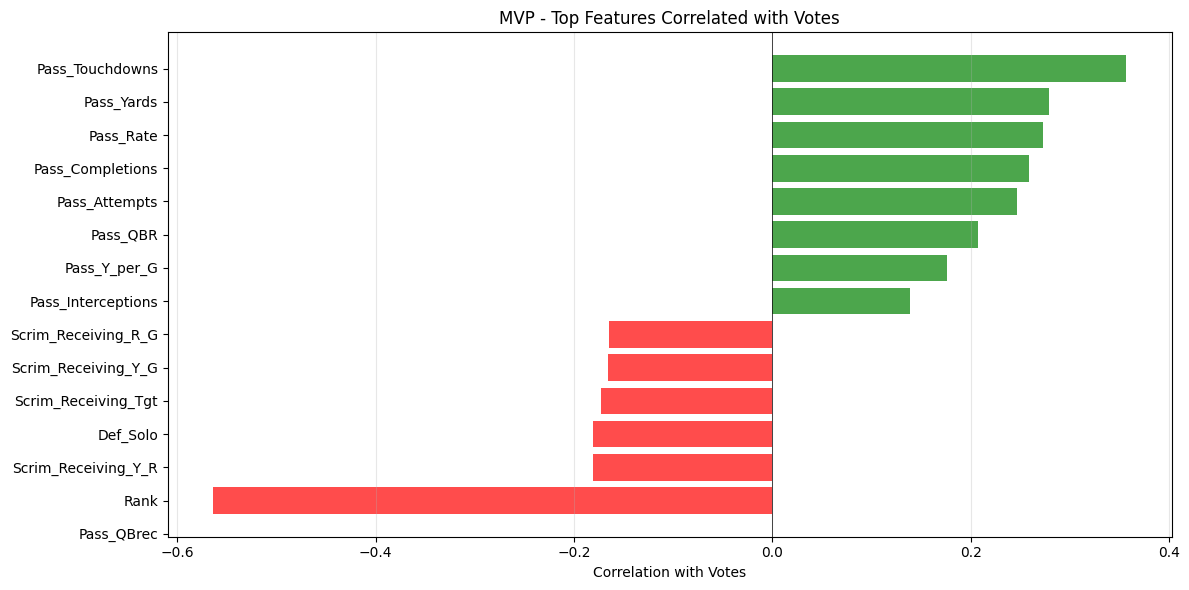

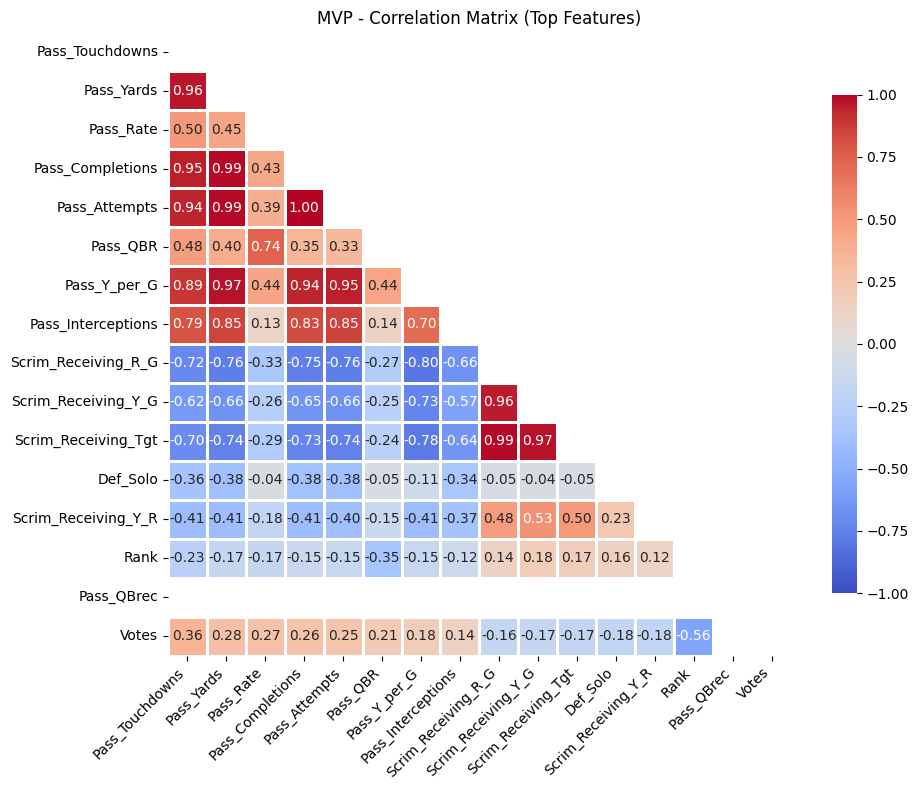


Top 10 Features Most Correlated with Votes for MVP:
--------------------------------------------------
 1. Pass_Touchdowns                | r = +0.357
 2. Pass_Yards                     | r = +0.279
 3. Pass_Rate                      | r = +0.273
 4. Pass_Completions               | r = +0.259
 5. Pass_Attempts                  | r = +0.247
 6. Pass_QBR                       | r = +0.207
 7. Pass_Y_per_G                   | r = +0.176
 8. Pass_Interceptions             | r = +0.139
 9. Scrim_Receiving_R_G            | r = -0.165
10. Scrim_Receiving_Y_G            | r = -0.166
--------------------------------------------------


In [6]:
visualize_award_data(mvp_df, "MVP")

The highest correlations with votes were:

Passing Touchdowns (r = +0.36)

Passing Yards (r = +0.28)

Passer Rating (r = +0.27)

Completions (r = +0.26)

Negative correlations were seen in receiving-related stats, indicating that non-QB metrics (like receptions or receiving yards) inversely relate to MVP voting.

This is likely due to the fact that MVP voting heavily favors quarterback performance, with passing efficiency and touchdown totals as the strongest predictors of success. A receiver has never won the award, it is most often quarterback or sometimes a running back.

### OPOY Visualizations


Generating visualizations for OPOY...


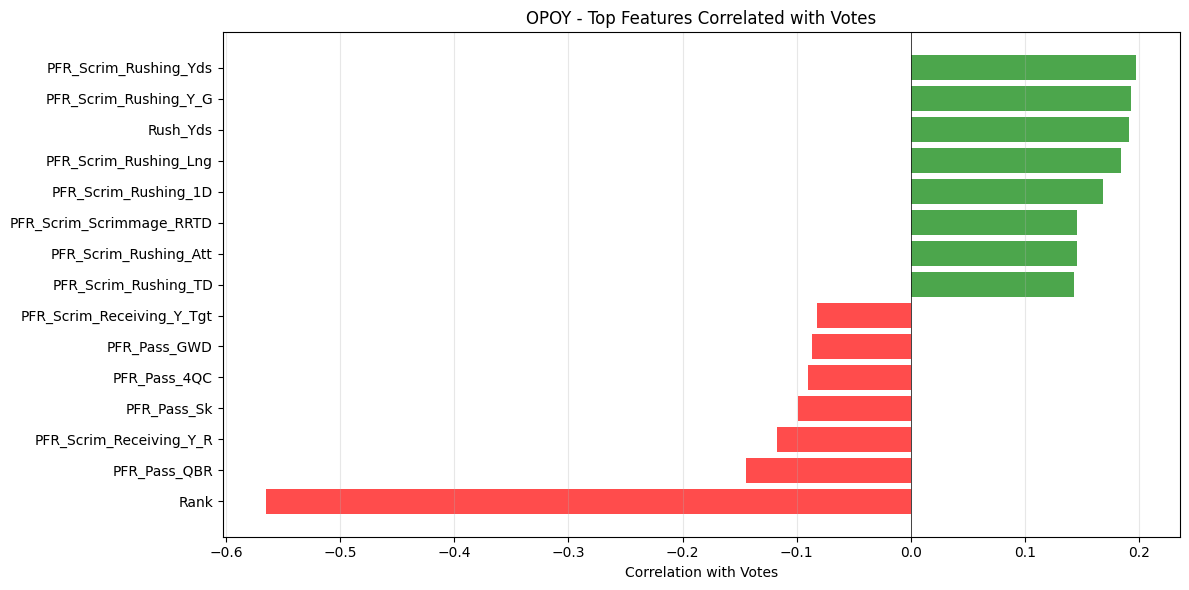

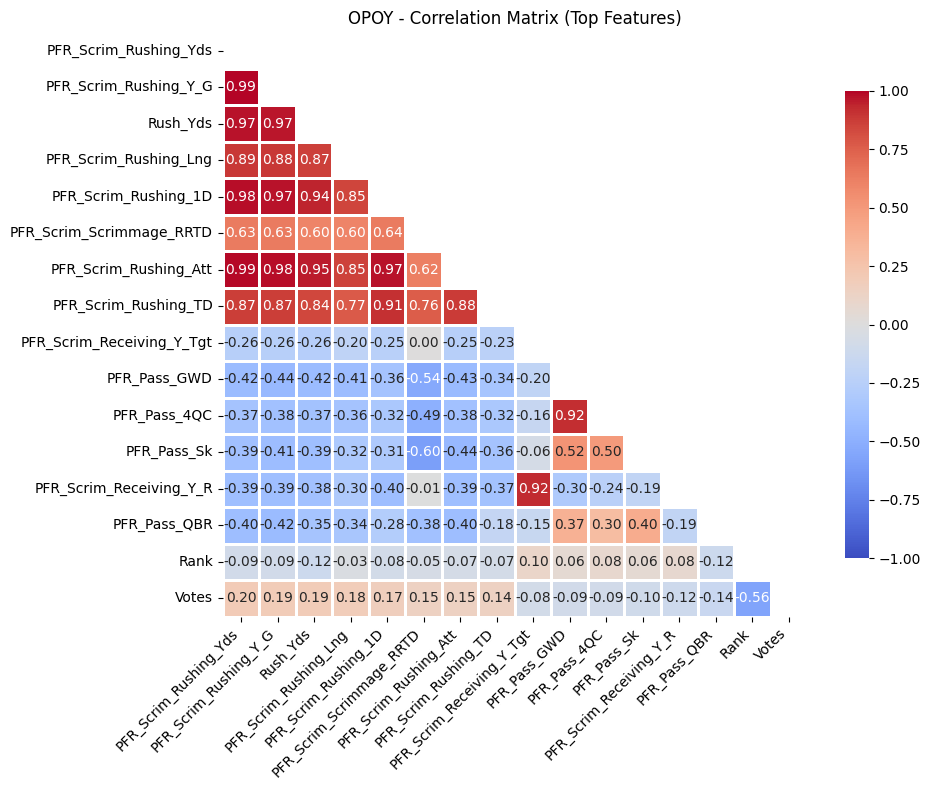


Top 10 Features Most Correlated with Votes for OPOY:
--------------------------------------------------
 1. PFR_Scrim_Rushing_Yds          | r = +0.198
 2. PFR_Scrim_Rushing_Y_G          | r = +0.193
 3. Rush_Yds                       | r = +0.191
 4. PFR_Scrim_Rushing_Lng          | r = +0.184
 5. PFR_Scrim_Rushing_1D           | r = +0.168
 6. PFR_Scrim_Scrimmage_RRTD       | r = +0.145
 7. PFR_Scrim_Rushing_Att          | r = +0.145
 8. PFR_Scrim_Rushing_TD           | r = +0.143
 9. PFR_Scrim_Receiving_Y_Tgt      | r = -0.082
10. PFR_Pass_GWD                   | r = -0.087
--------------------------------------------------


In [7]:
visualize_award_data(opoy_df, "OPOY")

Top correlated variables:

Rushing Yards (r ≈ +0.20)

Rushing Yards/Game (r ≈ +0.19)

Longest Rush (r ≈ +0.18)

Rushing Touchdowns (r ≈ +0.14)

Weak negative correlations appeared with passing stats, showing that OPOY tends to favor skill-position players (RBs and WRs) over QBs.

Efficiency and volume in rushing production most strongly impact OPOY results. This award is often given to a receiver or running back, as the MVP is more often a "quarterback award". However, it is also not given to wide receivers very often.

### DPOY Visualizations


Generating visualizations for DPOY...


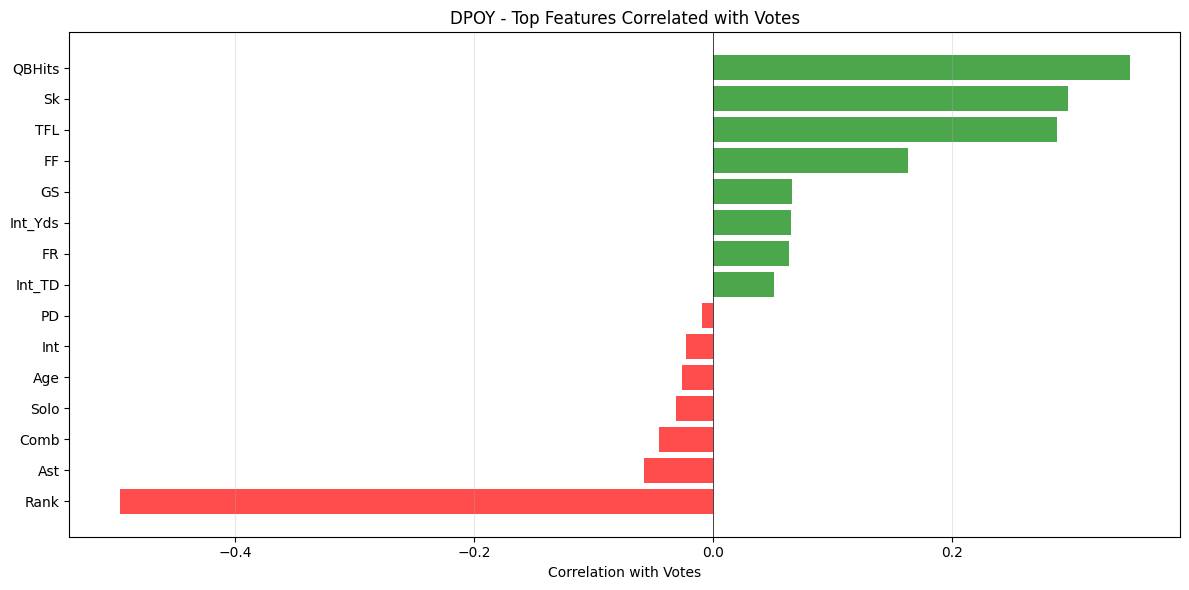

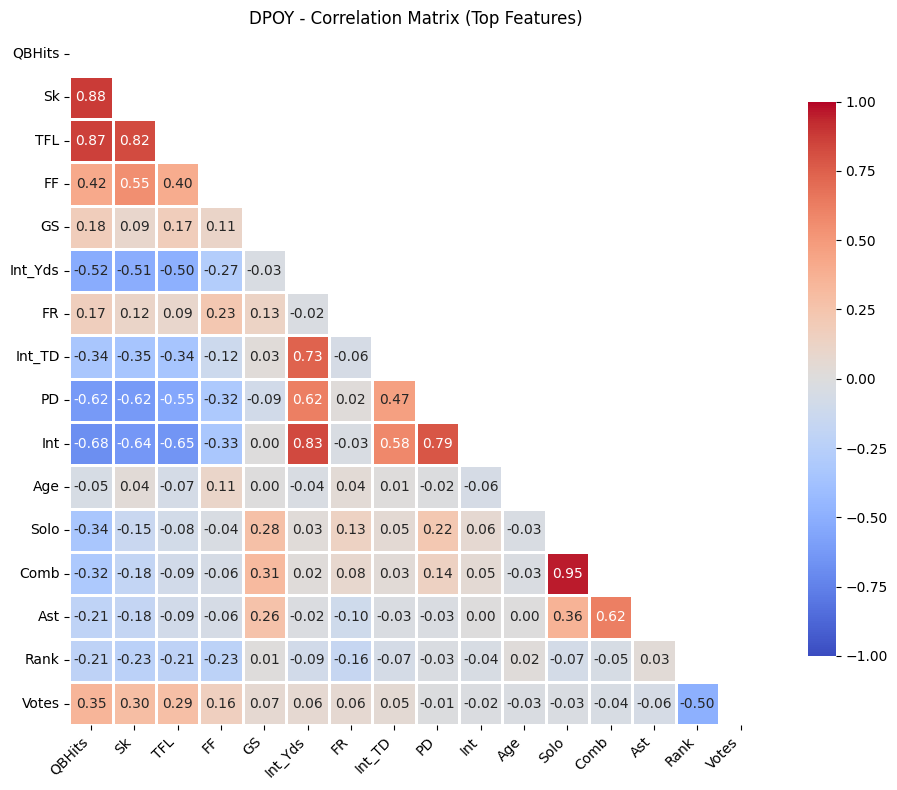


Top 10 Features Most Correlated with Votes for DPOY:
--------------------------------------------------
 1. QBHits                         | r = +0.349
 2. Sk                             | r = +0.297
 3. TFL                            | r = +0.288
 4. FF                             | r = +0.163
 5. GS                             | r = +0.066
 6. Int_Yds                        | r = +0.065
 7. FR                             | r = +0.063
 8. Int_TD                         | r = +0.051
 9. PD                             | r = -0.009
10. Int                            | r = -0.023
--------------------------------------------------


In [8]:
visualize_award_data(dpoy_df, "DPOY")

The highest correlations with votes were:

QB Hits (r = +0.35)
Sacks (r = +0.30)
Tackles for Loss (r = +0.29)
Forced Fumbles (r = +0.16)

Lower, but still slightly positive correlations were observed for Games Started, Interception Yards, and Fumble Recoveries, while tackling volume stats like Solo, Combined, and Assists were only weakly related or even slightly negative.

Voters often place the most weight on disruptive, high-impact defensive plays—especially those that directly affect the quarterback or create turnovers. Steady production stats such as tackles don’t seem to influence DPOY voting nearly as much. This can be due to a mix of things. Basic statistics like tackles without context are not that important. You don't want a cornerback to get a lot of tackles, it means they are likely getting beat on plays where they then have to stop the opposition.

Additionally, pass breakups were not a recorded stat for as long as sacks have been (even though quarterback hits have also not been around for that long). Even so, analyzing defensive back play goes way beyond basic box score statistics like pass breakups and interceptions. To really dive into that it would be helpful to look at snaps per target, receptions or yards allowed per snap, average separation from receivers. That could be a whole different project of just looking at defensive back performance.
When you play in the secondary you don't really want your name called that much, it often is because the receivers are burning you down the field consistently.

### OROY Visualizations


Generating visualizations for OROY...


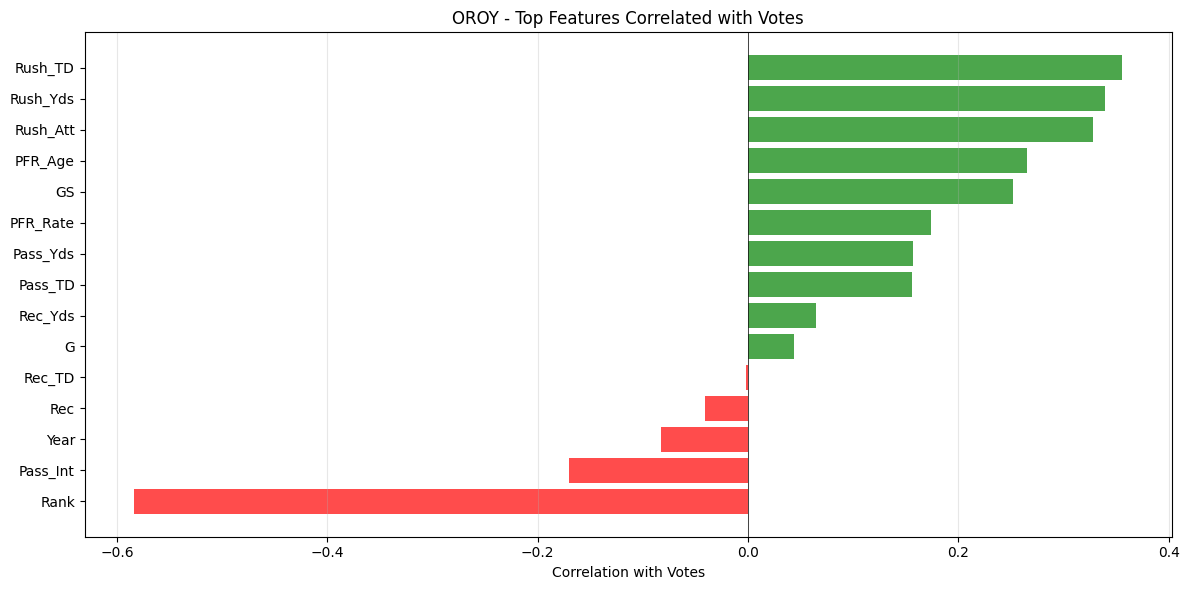

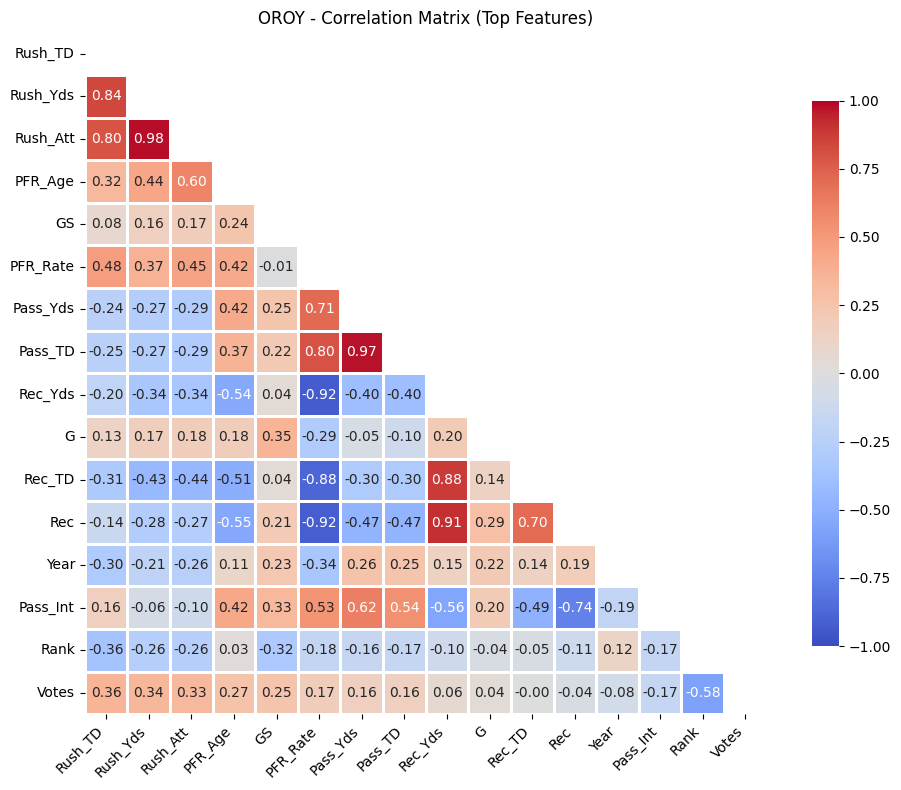


Top 10 Features Most Correlated with Votes for OROY:
--------------------------------------------------
 1. Rush_TD                        | r = +0.356
 2. Rush_Yds                       | r = +0.340
 3. Rush_Att                       | r = +0.328
 4. PFR_Age                        | r = +0.265
 5. GS                             | r = +0.252
 6. PFR_Rate                       | r = +0.174
 7. Pass_Yds                       | r = +0.157
 8. Pass_TD                        | r = +0.156
 9. Rec_Yds                        | r = +0.065
10. G                              | r = +0.044
--------------------------------------------------


In [9]:
visualize_award_data(oroy_df, "OROY")

The highest correlations with votes were:

Rushing Touchdowns (r = +0.36)
Rushing Yards (r = +0.34)
Rushing Attempts (r = +0.33)
Player Age (r = +0.27)
Games Started (r = +0.25)

Moderate positive relationships also appeared for Passer Rating (r = +0.17) and Passing Yards/Touchdowns (r ≈ +0.15), while receiving metrics such as Receptions and Receiving Yards showed only weak associations. Negative correlation was observed for Interceptions.

This pattern reflects the nature of the Offensive Rookie of the Year award — rookies who carry a heavy offensive workload and demonstrate scoring efficiency tend to earn the most recognition. Running backs who produce high rushing volume and touchdowns generally stand out, while quarterbacks benefit from efficiency rather than sheer yardage. The award favors the rookies who are immediate impacts on their team.

Often when a quarterback is put in right away, they don't see consistent success. This award is much more balanced for who it goes to than the offensive player of the year.

### DROY Visualizations


Generating visualizations for DROY...


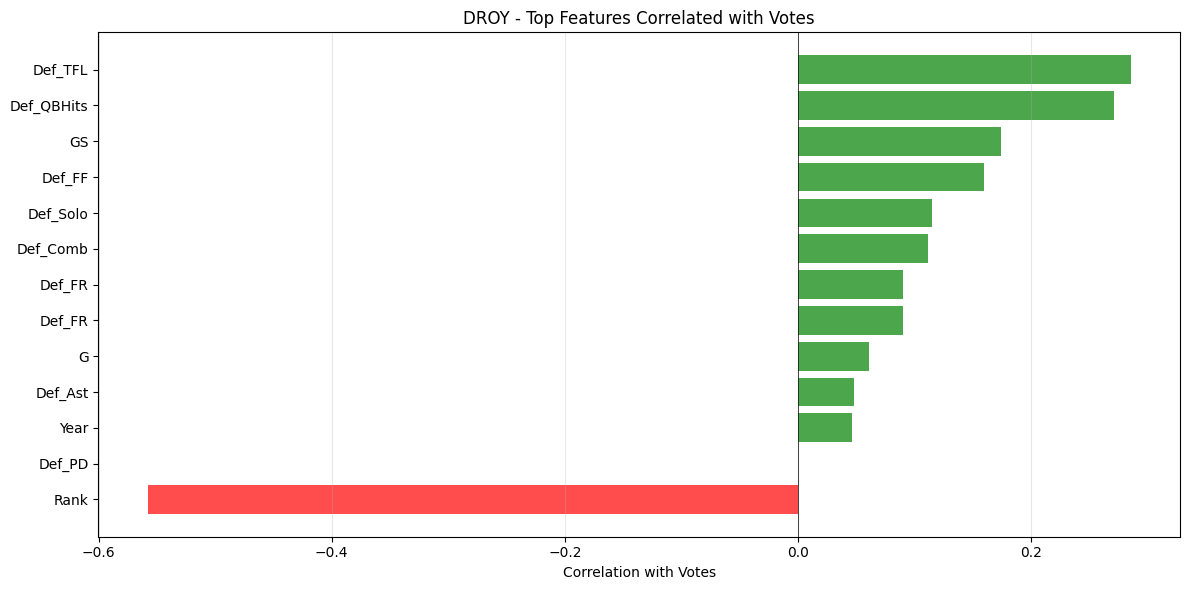

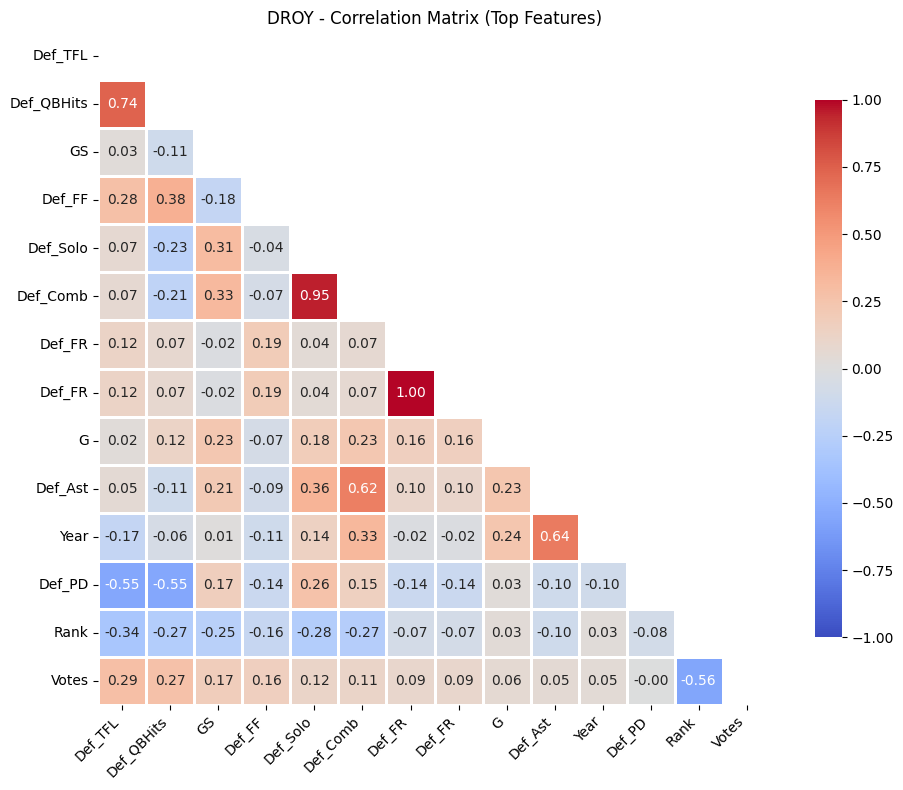


Top 10 Features Most Correlated with Votes for DROY:
--------------------------------------------------
 1. Def_TFL                        | r = +0.286
 2. Def_QBHits                     | r = +0.271
 3. GS                             | r = +0.174
 4. Def_FF                         | r = +0.160
 5. Def_Solo                       | r = +0.115
 6. Def_Comb                       | r = +0.111
 7. Def_FR                         | r = +0.090
 8. Def_FR                         | r = +0.090
 9. G                              | r = +0.061
10. Def_Ast                        | r = +0.048
--------------------------------------------------


In [10]:
visualize_award_data(droy_df, "DROY")

The highest correlations with votes were:

Tackles for Loss (r = +0.29)
Quarterback Hits (r = +0.27)
Games Started (r = +0.17)
Forced Fumbles (r = +0.16)

Smaller positive correlations appeared for Solo Tackles, Combined Tackles, and Fumble Recoveries, while features such as Passes Defended and Rank were weakly or negatively correlated.

Again defenders who generate disruptive plays and consistent backfield pressure tend to receive more votes, much like the DPOY trends. Experience and reliability (games started) play a moderate role, but the most decisive factors are impactful stats — tackles for loss, quarterback hits, and forced fumbles.

As we said before, it is harder to evaluate the secondary, and even linebackers too. While linebackers will rack up tackles, to really look into that you would need to also find the average depth of tackle (how far beyond the line of scrimmage a tackle is made), because you want your anchor in the middle of the field to be hitting people early.

# Prep and feature engineering

In [11]:
def prepare_features(df, award_name):
    """Prepare features for modeling"""
    print(f"\nPreparing features for {award_name}...")

    # Identify target variable
    target_col = None
    for col in ['Votes', 'votes', 'Vote', 'vote']:
        if col in df.columns:
            target_col = col
            break

    if target_col is None:
        print(f" Warning: No vote column found for {award_name}")
        return None, None

    # Select numeric features (excluding target)
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_features:
        numeric_features.remove(target_col)

    # Remove features that should not be used for prediction
    features_to_exclude = []

    # 1. Remove Rank (data leakage - it's derived from votes)
    for col in numeric_features:
        col_lower = col.lower()
        if 'rank' in col_lower:
            features_to_exclude.append(col)
            print(f"   Removing '{col}' - Rank is derived from votes (data leakage)")

    # 2. Remove Year (temporal information - needs special handling)
    for col in numeric_features:
        col_lower = col.lower()
        if col_lower in ['year', 'season']:
            features_to_exclude.append(col)
            print(f"   Removing '{col}' - Year/Season requires temporal modeling approach")

    # 3. Remove problematic features with misleading zeros (QB stats for non-QBs)
    for col in numeric_features:
        col_lower = col.lower()
        if 'qbr' in col_lower or 'qb_rating' in col_lower or 'passer_rating' in col_lower:
            zero_count = (df[col] == 0).sum()
            total_count = len(df[col].dropna())
            if total_count > 0 and zero_count / total_count > 0.5:
                features_to_exclude.append(col)
                print(f"   Removing '{col}' - {zero_count}/{total_count} ({100*zero_count/total_count:.1f}%) are zeros")

    # Remove identified features
    numeric_features = [f for f in numeric_features if f not in features_to_exclude]

    print(f"  Target variable: {target_col}")
    print(f"  Number of features: {len(numeric_features)}")
    print(f"  Features: {numeric_features}")

    # Remove rows with missing target values
    df_clean = df[df[target_col].notna()].copy()

    # Handle missing values in features
    X = df_clean[numeric_features].fillna(df_clean[numeric_features].median())
    y = df_clean[target_col]

    print(f"  Final dataset size: {len(df_clean)} samples")
    print(f"  Features shape: {X.shape}")

    return X, y

# Prepare features for all awards
prepared_data = {}
for name, df in datasets.items():
    X, y = prepare_features(df, name)
    if X is not None:
        prepared_data[name] = {'X': X, 'y': y}


Preparing features for MVP...
   Removing 'Rank' - Rank is derived from votes (data leakage)
   Removing 'Year' - Year/Season requires temporal modeling approach
  Target variable: Votes
  Number of features: 49
  Features: ['Unnamed: 0', 'Games', 'Games_Started', 'Age', 'Pass_QBrec', 'Pass_Rate', 'Pass_QBR', 'Pass_Y_per_A', 'Pass_AY_per_A', 'Pass_Y_per_C', 'Pass_Y_per_G', 'Pass_NY_per_A', 'Pass_ANY_per_A', 'Pass_Sk', 'Pass_4QC', 'Pass_GWD', 'Pass_Completions', 'Pass_Attempts', 'Pass_Yards', 'Pass_Touchdowns', 'Pass_Interceptions', 'Rush_Attempts', 'Rush_Yards', 'Rush_Touchdowns', 'Scrim_Receiving_Tgt', 'Scrim_Receiving_Y_R', 'Scrim_Receiving_1D', 'Scrim_Receiving_Succ_Pct', 'Scrim_Receiving_Lng', 'Scrim_Receiving_R_G', 'Scrim_Receiving_Y_G', 'Scrim_Receiving_Ctch_Pct', 'Scrim_Receiving_Y_Tgt', 'Rec_Receptions', 'Rec_Yards', 'Rec_Touchdowns', 'Scrim_Scrimmage_Touch', 'Scrim_Scrimmage_Y_Tch', 'Scrim_Scrimmage_YScm', 'Scrim_Scrimmage_RRTD', 'Def_Solo', 'Def_Sk', 'Def_Int', 'Scrim_Rushin

1. Data leakage prevention
   - Removed 'Rank' features: Rankings are directly derived from vote totals, so t going to be very strong predictors that would artificially inflate model performance. The rankings are just showing who got the most votes without the vote count.
   
2. Temporal considerations
   - Removed 'Year'/'Season': Including year as a numeric feature assumes a linear relationship with votes, which is incorrect. Award voting patterns may shift over time, but we would need to use time-series modeling, not treating year as just another feature.
   
3. Position specific stats
   - Filtered out QB-specific stats (QBR, passer rating) that show more than 50% zeros. These zeros are non-QBs who don't have those stats, which will create misleading patterns and hurt model generalization.

4. Missing value strategy
   - Used median imputation for features (robust to outliers)
   - Dropped rows with missing target values (can't train without labels)

# Feature Engineering
Justification: Individual counting stats (yards, TDs) don't account for efficiency or opportunity. Interaction features capture RATE stats that better measure player quality (e.g., yards per attempt > total yards). These are commonly used in NFL analytics and award discussions.

In [12]:
def create_interaction_features(X, award_name):
    """Create meaningful interaction features based on football statistics

    Rationale:
    - Efficiency metrics (yards/attempt) often matter more than volume stats
    - TD/INT ratios capture decision-making quality
    - Per-game and per-opportunity stats normalize for playing time
    - These features mirror stats actually discussed by voters and analysts
    """
    print(f"\n{award_name} - Creating Interaction Features")
    print("-" * 60)

    X_enhanced = X.copy()
    new_features = []

    # Helper function to safely create ratio features
    def safe_ratio(numerator, denominator, default=0):
        """Create ratio while handling division by zero and infinities"""
        ratio = numerator / (denominator + 1e-6)
        ratio = ratio.replace([np.inf, -np.inf], default)
        ratio = ratio.fillna(default)
        return ratio

    # === PASSING EFFICIENCY (MVP, OROY - QB focused) ===
    if 'Pass_Yards' in X.columns and 'Pass_Attempts' in X.columns:
        X_enhanced['Pass_YPA'] = safe_ratio(X['Pass_Yards'], X['Pass_Attempts'])
        new_features.append('Pass_YPA (Yards per attempt)')

    if 'Pass_Touchdowns' in X.columns and 'Pass_Attempts' in X.columns:
        X_enhanced['Pass_TD_Rate'] = safe_ratio(X['Pass_Touchdowns'], X['Pass_Attempts']) * 100
        new_features.append('Pass_TD_Rate (TD% per attempt)')

    if 'Pass_Touchdowns' in X.columns and 'Pass_Interceptions' in X.columns:
        X_enhanced['Pass_TD_INT_Ratio'] = safe_ratio(X['Pass_Touchdowns'], X['Pass_Interceptions'], default=0)
        new_features.append('Pass_TD_INT_Ratio (TD to INT ratio)')

    if 'Pass_Completions' in X.columns and 'Pass_Attempts' in X.columns:
        X_enhanced['Pass_Comp_Pct'] = safe_ratio(X['Pass_Completions'], X['Pass_Attempts']) * 100
        new_features.append('Pass_Comp_Pct (Completion %)')

    # === RUSHING EFFICIENCY (OPOY, OROY - RB focused) ===
    if 'Rush_Yds' in X.columns and 'Rush_Att' in X.columns:
        X_enhanced['Rush_YPC'] = safe_ratio(X['Rush_Yds'], X['Rush_Att'])
        new_features.append('Rush_YPC (Yards per carry)')

    if 'Rush_TD' in X.columns and 'Rush_Att' in X.columns:
        X_enhanced['Rush_TD_Rate'] = safe_ratio(X['Rush_TD'], X['Rush_Att']) * 100
        new_features.append('Rush_TD_Rate (TD% per carry)')

    # PFR Scrimmage rushing efficiency (OPOY specific)
    if 'PFR_Scrim_Rushing_Yds' in X.columns and 'PFR_Scrim_Rushing_Att' in X.columns:
        X_enhanced['PFR_Rush_YPC'] = safe_ratio(X['PFR_Scrim_Rushing_Yds'], X['PFR_Scrim_Rushing_Att'])
        new_features.append('PFR_Rush_YPC (PFR yards per carry)')

    if 'PFR_Scrim_Rushing_TD' in X.columns and 'PFR_Scrim_Rushing_Att' in X.columns:
        X_enhanced['PFR_Rush_TD_Rate'] = safe_ratio(X['PFR_Scrim_Rushing_TD'], X['PFR_Scrim_Rushing_Att']) * 100
        new_features.append('PFR_Rush_TD_Rate (PFR TD% per carry)')

    # === RECEIVING EFFICIENCY (OPOY, OROY - WR/TE focused) ===
    if 'Rec_Yds' in X.columns and 'Rec' in X.columns:
        X_enhanced['Rec_YPR'] = safe_ratio(X['Rec_Yds'], X['Rec'])
        new_features.append('Rec_YPR (Yards per reception)')

    if 'Rec_TD' in X.columns and 'Rec' in X.columns:
        X_enhanced['Rec_TD_Rate'] = safe_ratio(X['Rec_TD'], X['Rec']) * 100
        new_features.append('Rec_TD_Rate (TD% per reception)')

    # === DEFENSIVE EFFICIENCY (DPOY, DROY) ===
    # Sack efficiency relative to QB hits
    if 'Sk' in X.columns and 'QBHits' in X.columns:
        X_enhanced['Sack_Conversion_Rate'] = safe_ratio(X['Sk'], X['QBHits'])
        new_features.append('Sack_Conversion_Rate (Sacks per QB hit)')

    if 'Def_TFL' in X.columns and 'Def_QBHits' in X.columns:
        X_enhanced['Def_Sack_Conv_Rate'] = safe_ratio(X['Def_TFL'], X['Def_QBHits'])
        new_features.append('Def_Sack_Conv_Rate (TFL per QB hit)')

    # Turnover creation (DPOY)
    if 'FF' in X.columns and 'TFL' in X.columns:
        X_enhanced['Disruptive_Play_Rate'] = (X['FF'].fillna(0) + X['TFL'].fillna(0)) / 2
        new_features.append('Disruptive_Play_Rate (Avg FF + TFL)')

    if 'Def_FF' in X.columns and 'Def_TFL' in X.columns:
        X_enhanced['Def_Disruptive_Rate'] = (X['Def_FF'].fillna(0) + X['Def_TFL'].fillna(0)) / 2
        new_features.append('Def_Disruptive_Rate (Avg FF + TFL)')

    # Total tackles efficiency (Solo vs Assisted)
    if 'Solo' in X.columns and 'Comb' in X.columns:
        X_enhanced['Solo_Tackle_Rate'] = safe_ratio(X['Solo'], X['Comb'])
        new_features.append('Solo_Tackle_Rate (Solo / Total tackles)')

    if 'Def_Solo' in X.columns and 'Def_Comb' in X.columns:
        X_enhanced['Def_Solo_Rate'] = safe_ratio(X['Def_Solo'], X['Def_Comb'])
        new_features.append('Def_Solo_Rate (Solo / Total tackles)')

    # === AVAILABILITY/USAGE (All awards) ===
    # Per-game stats normalize for missed games
    if 'Pass_Yards' in X.columns and 'GS' in X.columns:
        X_enhanced['Pass_YPG'] = safe_ratio(X['Pass_Yards'], X['GS'])
        new_features.append('Pass_YPG (Pass yards per game started)')

    if 'Rush_Yds' in X.columns and 'GS' in X.columns:
        X_enhanced['Rush_YPG'] = safe_ratio(X['Rush_Yds'], X['GS'])
        new_features.append('Rush_YPG (Rush yards per game started)')

    if 'Rec_Yds' in X.columns and 'GS' in X.columns:
        X_enhanced['Rec_YPG'] = safe_ratio(X['Rec_Yds'], X['GS'])
        new_features.append('Rec_YPG (Rec yards per game started)')

    # Total offensive production (OPOY, MVP)
    if 'Pass_Touchdowns' in X.columns and 'Rush_TD' in X.columns:
        X_enhanced['Total_TD'] = X['Pass_Touchdowns'].fillna(0) + X['Rush_TD'].fillna(0)
        new_features.append('Total_TD (Pass + Rush TDs)')

    if 'Pass_Yards' in X.columns and 'Rush_Yds' in X.columns:
        X_enhanced['Total_Yards'] = X['Pass_Yards'].fillna(0) + X['Rush_Yds'].fillna(0)
        new_features.append('Total_Yards (Pass + Rush yards)')

    # Replace any remaining NaN or inf values
    X_enhanced = X_enhanced.replace([np.inf, -np.inf], 0)
    X_enhanced = X_enhanced.fillna(0)

    # Print summary
    print(f"  Created {len(new_features)} interaction features:")
    for i, feat in enumerate(new_features, 1):
        print(f"    {i:2}. {feat}")
    print(f"\n  Original features: {X.shape[1]}")
    print(f"  Enhanced features: {X_enhanced.shape[1]}")
    print(f"  New features added: {len(new_features)}")

    # Verify no NaN values remain
    nan_count = X_enhanced.isna().sum().sum()
    inf_count = np.isinf(X_enhanced.select_dtypes(include=[np.number])).sum().sum()
    print(f"  NaN values: {nan_count}")
    print(f"  Inf values: {inf_count}")

    return X_enhanced

# Feature Selection

In [13]:
def select_best_features_cv(X, y, award_name, k = 5, test_size = 0.2, random_state = 3540):
    """
    Use multiple feature selection methods with proper train/test split
    and cross-validation to identify best features

    Methods:
    1. Univariate Selection (F-statistic) - statistical relationship
    2. Recursive Feature Elimination (RFE) - backward elimination
    3. Lasso Regularization (L1) - penalizes weak features
    4. Random Forest Feature Importance - non-linear relationships

    Returns train/test splits with selected features and scaling applied
    """
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    import warnings
    from sklearn.exceptions import ConvergenceWarning

    # Train/test split (temporal: no shuffle for time-series data)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )

    # Scale features (fit on training data only!)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    # Ensure k is not larger than number of features
    k = min(k, X_train_scaled.shape[1])

    # Method 1: Univariate Feature Selection (F-statistic)
    selector_f = SelectKBest(score_func=f_regression, k=k)
    selector_f.fit(X_train_scaled, y_train)
    f_scores = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'F_Score': selector_f.scores_
    }).sort_values('F_Score', ascending=False)
    univariate_features = set(f_scores.head(k)['Feature'].tolist())

    # Method 2: Recursive Feature Elimination with CV
    estimator = Ridge(alpha=1.0)
    selector_rfe = RFE(estimator, n_features_to_select=k, step=1)
    selector_rfe.fit(X_train_scaled, y_train)
    rfe_features = set(X_train_scaled.columns[selector_rfe.support_].tolist())

    # Method 3: Lasso (L1 Regularization) with CV
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        lasso = LassoCV(cv=5, random_state=random_state, max_iter=50000, tol=1e-3)
        lasso.fit(X_train_scaled, y_train)

    # Extract lasso features
    lasso_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Coefficient': np.abs(lasso.coef_)
    }).sort_values('Coefficient', ascending=False)
    lasso_features = set(lasso_importance[lasso_importance['Coefficient'] > 0]['Feature'].tolist())

    # Method 4: Random Forest Feature Importance with CV
    from sklearn.model_selection import cross_val_score
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state, max_depth=10)
    rf.fit(X_train_scaled, y_train)
    rf_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    rf_features = set(rf_importance.head(k)['Feature'].tolist())

    # Combine methods: features selected by at least 2 methods
    all_features = [univariate_features, rfe_features, lasso_features, rf_features]
    feature_votes = {}
    for feature_set in all_features:
        for feature in feature_set:
            feature_votes[feature] = feature_votes.get(feature, 0) + 1

    # Select features chosen by at least 2 methods
    consensus_features = [f for f, votes in feature_votes.items() if votes >= 2]

    # If too few features, take top k by vote count
    if len(consensus_features) < k // 2:
        sorted_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)
        consensus_features = [f for f, _ in sorted_features[:k]]

    # Apply feature selection to both train and test sets
    X_train_selected = X_train_scaled[consensus_features]
    X_test_selected = X_test_scaled[consensus_features]

    return {
        'X_train': X_train_selected,
        'X_test': X_test_selected,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'selected_features': consensus_features,
        'feature_votes': feature_votes,
        'method_results': {
            'univariate': univariate_features,
            'rfe': rfe_features,
            'lasso': lasso_features,
            'random_forest': rf_features
        },
        'importance_dfs': {
            'f_scores': f_scores,
            'lasso_importance': lasso_importance,
            'rf_importance': rf_importance
        }
    }

# Create enhanced data
enhanced_data = {}
for name, data in prepared_data.items():
    X_enhanced = create_interaction_features(data['X'], name)
    enhanced_data[name] = {'X': X_enhanced, 'y': data['y']}

# Apply feature selection with train/test split to all awards
modeling_data = {}
for name, data in enhanced_data.items():
    modeling_data[name] = select_best_features_cv(data['X'], data['y'], name, k=20)


MVP - Creating Interaction Features
------------------------------------------------------------
  Created 4 interaction features:
     1. Pass_YPA (Yards per attempt)
     2. Pass_TD_Rate (TD% per attempt)
     3. Pass_TD_INT_Ratio (TD to INT ratio)
     4. Pass_Comp_Pct (Completion %)

  Original features: 49
  Enhanced features: 53
  New features added: 4
  NaN values: 0
  Inf values: 0

OPOY - Creating Interaction Features
------------------------------------------------------------
  Created 6 interaction features:
     1. Rush_YPC (Yards per carry)
     2. Rush_TD_Rate (TD% per carry)
     3. PFR_Rush_YPC (PFR yards per carry)
     4. PFR_Rush_TD_Rate (PFR TD% per carry)
     5. Rush_YPG (Rush yards per game started)
     6. Rec_YPG (Rec yards per game started)

  Original features: 61
  Enhanced features: 67
  New features added: 6
  NaN values: 0
  Inf values: 0

DPOY - Creating Interaction Features
------------------------------------------------------------
  Created 3 inter

1. Efficiency > Volume in award voting

   Award voters consistently prioritize efficiency over raw volume   
   Real-world parallel:
   - 2019 MVP: Lamar Jackson (3,127 pass yards but 9.0 YPA, 36 TD / 6 INT)
   - Patrick Mahomes commended for TD/INT ratio (50/12 in MVP year)
   - Derrick Henry's rushing efficiency (5.4 YPC) mentioned in OPOY discussions
   
   Our interaction features capture these efficiency metrics that voters
   actually discuss and value.

2. Position appropriate metrics
   Different positions require different success metrics:   
   Quarterbacks (MVP, OROY):
   - Pass_YPA: Explosiveness
   - Pass_TD_INT_Ratio: Ball security and accuracy
   - Pass_Comp_Pct: Accuracy and effectiveness
   - Total_TD/Total_Yards: Dual-threat ability (rushing + passing)
   
   Running backs (OPOY, OROY):
   - Rush_YPC: Elusiveness (and offensive line quality by-product)
   - Rush_TD_Rate: Red zone effectiveness
   - Rush_YPG: Workload-adjusted production (key for injury seasons)
   
   Receivers (OPOY, OROY):
   - Rec_YPR: Big-play ability, route-running, getting open
   - Rec_TD_Rate: Red zone target share
   - Rec_YPG: Consistency and reliability
   
   Defenders (DPOY, DROY):
   - Sack_Conversion_Rate: Pass rush efficiency (sacks vs. pressures)
   - Disruptive_Play_Rate: Game-changing plays (FF, TFL)
   - Solo_Tackle_Rate: Individual effort vs. assisted tackles

3. Handling missing data and edge cases

   safe_ratio() function prevents three critical issues:
   
   a) Division by Zero:
      - Added 1e-6 to denominators (prevents crashes)
      - Example: 0 pass attempts → YPA = 0 (not undefined)
   
   b) Infinite Values:
      - Replaced inf/-inf with 0 (prevents model training failures)
      - Example: 10 TDs / 0 INTs → TD/INT ratio = 0 (not infinity)
      - Justification: If denominator is 0, the stat isn't meaningful
   
   c) NaN Propagation:
      - Filled NaN with 0 (maintains data integrity)
      - Example: Missing rushing attempts → YPC = 0 (not NaN)
   
   Design Choice: Default to 0 rather than median/mean
   - Rationale: Missing data often means "didn't do this activity"
   - Example: A WR with 0 pass attempts shouldn't get average QB stats

4. Football domain knowledge embedded
   
   These aren't arbitrary mathematical combinations - they mirror
   actual football analysis:
   
   - TD/INT Ratio: NFL analyst key QB metric
   - YPC (Yards Per Carry): Standard RB efficiency benchmark
   - YPA (Yards Per Attempt): QB efficiency metric
   - Per-game stats: Normalizes for players who miss games (injuries)
   - Solo tackle rate: Distinguishes playmakers from cleanup tacklers
   
   These are some metrics you'd see on:
   - ESPN/NFL.com player pages
   - Pro Football Reference advanced stats
   - Broadcast graphics during games
   - Award voter commentary

5. Multicollinearity considerations

   Potential issue: Interaction features may correlate with base features
   
   Example:
   - Pass_Yards AND Pass_YPA both strongly predict MVP votes
   - But Pass_YPA = Pass_Yards / Pass_Attempts (derived relationship)
   
   Why this is acceptable:
   - Tree-based models (Random Forest, XGBoost) handle multicollinearity well
   - Feature importance will reveal redundant features
   - Regularized models (Lasso) will naturally select important features
   - The interaction often has DIFFERENT predictive power than components

In [14]:
def visualize_feature_selection(result, award_name):
    """
    Visualize feature selection results for a specific award

    Parameters:
    -----------
    result : dict
        Output from select_best_features_cv() function
    award_name : str
        Name of the award (e.g., 'MVP', 'OPOY', etc.)
    """

    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"{award_name} Feature Selection Results")
    print(f"{'='*60}")
    print(f"  Selected features: {len(result['selected_features'])}")
    print(f"  Training samples: {len(result['X_train'])}")
    print(f"  Test samples: {len(result['X_test'])}")
    print(f"\nTop 10 features by consensus votes:")
    for feature, votes in sorted(result['feature_votes'].items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {feature}: {votes}/4 methods")

    # ============ VISUALIZATIONS ============

    # Create 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Feature Consensus Votes
    vote_df = pd.DataFrame(list(result['feature_votes'].items()), columns=['Feature', 'Votes'])
    vote_df = vote_df.sort_values('Votes', ascending=False).head(20)

    ax1 = axes[0, 0]
    colors = ['#d62728' if v >= 3 else '#ff7f0e' if v >= 2 else '#1f77b4' for v in vote_df['Votes']]
    ax1.barh(vote_df['Feature'], vote_df['Votes'], color=colors)
    ax1.set_xlabel('Number of Methods Selecting Feature', fontsize=12)
    ax1.set_title(f'{award_name}: Feature Selection Consensus\n(Red=3-4 methods, Orange=2 methods, Blue=1 method)',
                  fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 4)
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)

    # Plot 2: Method Overlap (Bar chart)
    ax2 = axes[0, 1]
    method_names = ['Univariate\n(F-stat)', 'RFE', 'Lasso\n(L1)', 'Random\nForest']
    method_counts = [
        len(result['method_results']['univariate']),
        len(result['method_results']['rfe']),
        len(result['method_results']['lasso']),
        len(result['method_results']['random_forest'])
    ]
    bars = ax2.bar(method_names, method_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax2.set_ylabel('Number of Features Selected', fontsize=12)
    ax2.set_title(f'{award_name}: Features Selected by Each Method', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, max(method_counts) * 1.2)
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    # Plot 3: Top Features by F-Score
    ax3 = axes[1, 0]
    top_f = result['importance_dfs']['f_scores'].head(15)
    ax3.barh(top_f['Feature'], top_f['F_Score'], color='#1f77b4')
    ax3.set_xlabel('F-Statistic Score', fontsize=12)
    ax3.set_title(f'{award_name}: Top 15 Features by Univariate F-Score', fontsize=14, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)

    # Plot 4: Top Features by Random Forest Importance
    ax4 = axes[1, 1]
    top_rf = result['importance_dfs']['rf_importance'].head(15)
    ax4.barh(top_rf['Feature'], top_rf['Importance'], color='#d62728')
    ax4.set_xlabel('Random Forest Importance', fontsize=12)
    ax4.set_title(f'{award_name}: Top 15 Features by RF Importance', fontsize=14, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ============ HEATMAP ============

    print(f"\n{'='*60}")
    print(f"{award_name} - METHOD AGREEMENT MATRIX")
    print(f"{'='*60}")

    # Create agreement matrix
    selected_by_method = result['method_results']
    all_unique_features = set()
    for features in selected_by_method.values():
        all_unique_features.update(features)

    agreement_matrix = []
    for feature in sorted(all_unique_features):
        row = [
            1 if feature in selected_by_method['univariate'] else 0,
            1 if feature in selected_by_method['rfe'] else 0,
            1 if feature in selected_by_method['lasso'] else 0,
            1 if feature in selected_by_method['random_forest'] else 0
        ]
        agreement_matrix.append(row)

    agreement_df = pd.DataFrame(
        agreement_matrix,
        columns=['Univariate', 'RFE', 'Lasso', 'RF'],
        index=sorted(all_unique_features)
    )

    # Only show features selected by at least one method
    agreement_df = agreement_df[agreement_df.sum(axis=1) > 0]

    # Show top features by total votes
    agreement_df['Total'] = agreement_df.sum(axis=1)
    agreement_df = agreement_df.sort_values('Total', ascending=False).head(25)
    agreement_df = agreement_df.drop('Total', axis=1)

    plt.figure(figsize=(10, 12))
    sns.heatmap(agreement_df, cmap='YlOrRd', cbar_kws={'label': 'Selected (1) or Not (0)'},
                linewidths=0.5, annot=True, fmt='d', center=0.5)
    plt.title(f'{award_name}: Top 25 Features - Method Agreement Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Selection Method', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

### MVP Features


MVP Feature Selection Results
  Selected features: 19
  Training samples: 180
  Test samples: 45

Top 10 features by consensus votes:
  Pass_Touchdowns: 4/4 methods
  Pass_Rate: 4/4 methods
  Unnamed: 0: 3/4 methods
  Pass_Yards: 3/4 methods
  Pass_Completions: 3/4 methods
  Pass_Comp_Pct: 3/4 methods
  Scrim_Rushing_1D: 3/4 methods
  Pass_YPA: 2/4 methods
  Pass_TD_Rate: 2/4 methods
  Pass_QBR: 2/4 methods


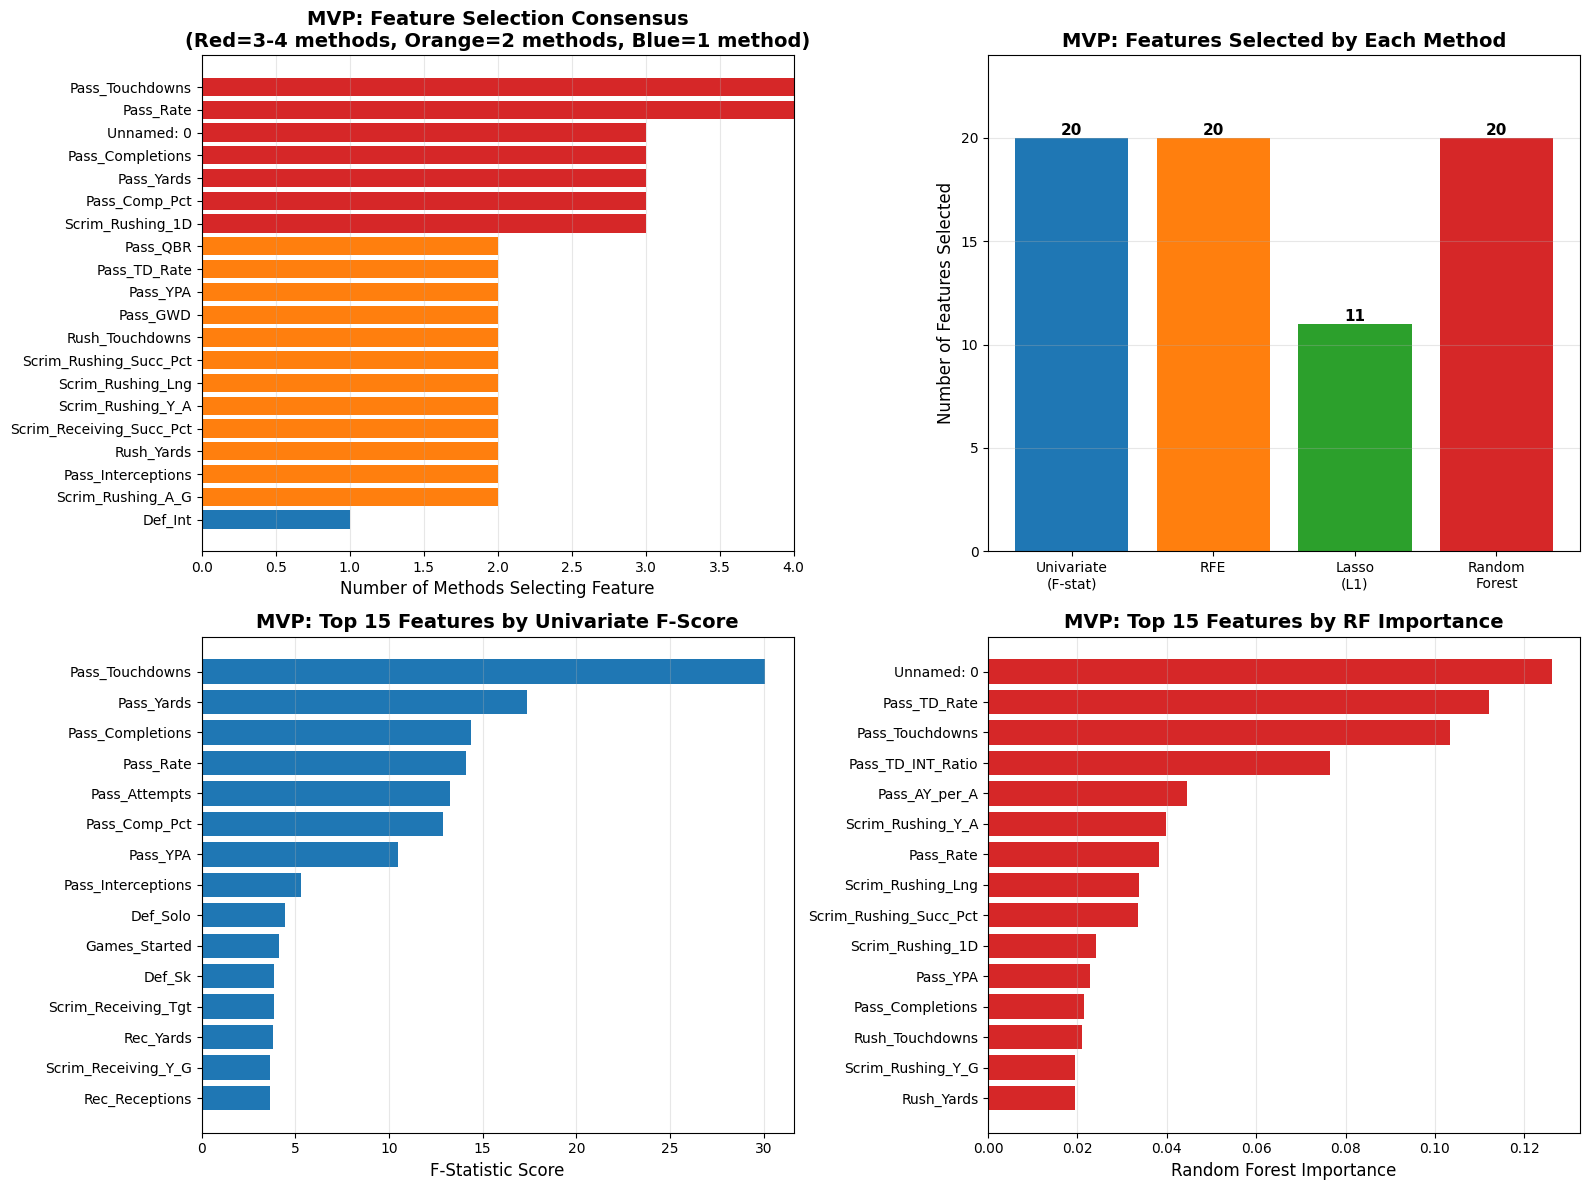


MVP - METHOD AGREEMENT MATRIX


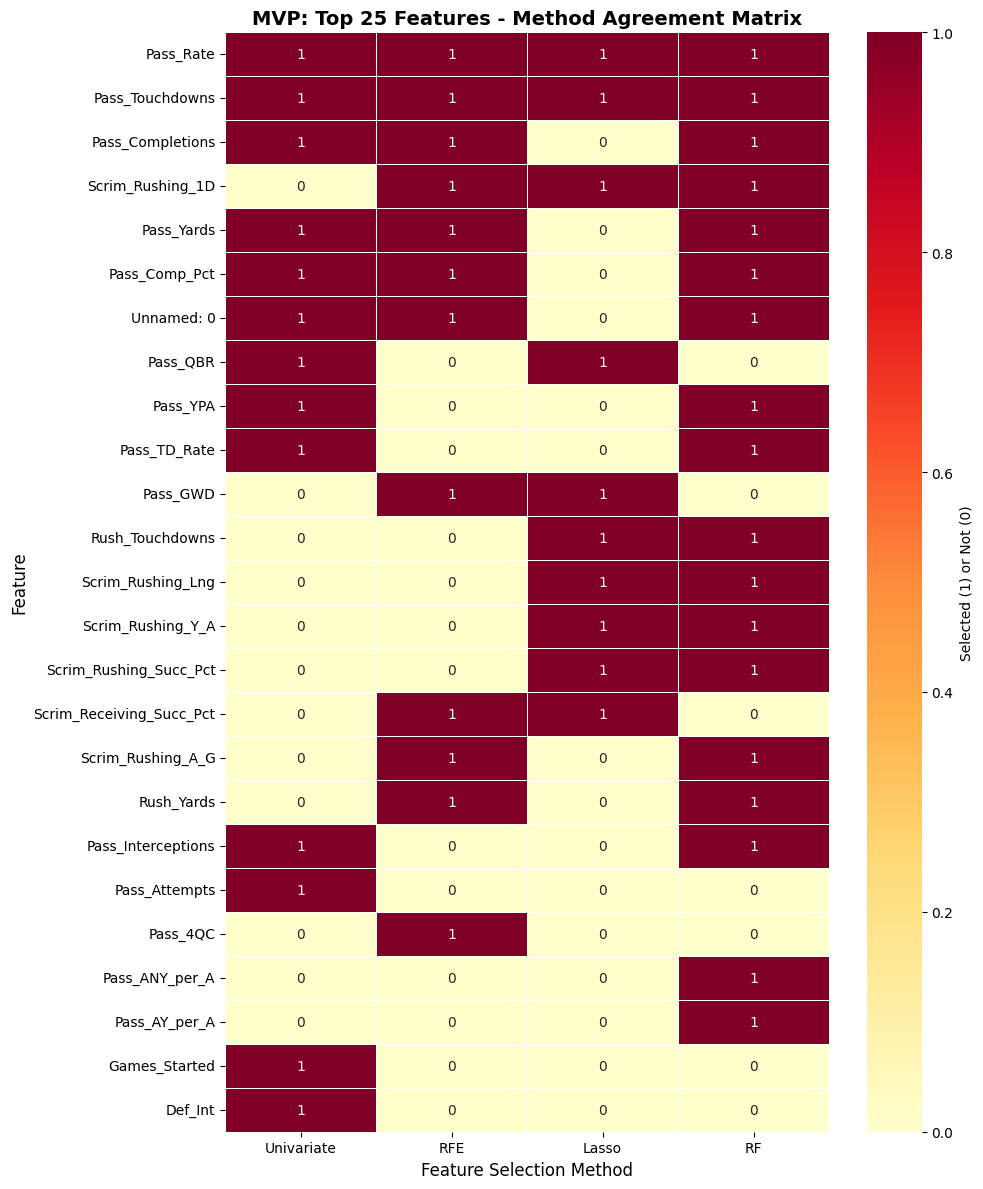

In [15]:
result = modeling_data['MVP']
visualize_feature_selection(result, 'MVP')

**MVP Feature Selection Analysis – Summary**

**Core Passing Metrics Dominate**
Pass rate and passing touchdowns were chosen by all four selection methods—no surprise, since MVPs are almost always quarterbacks. Only five non-QBs have won since 1980.

---

**Efficiency Matters**
Completion percentage, touchdown rate, yards per attempt, and QBR all ranked highly. These capture accuracy, explosiveness, and overall effectiveness—traits seen in **Lamar Jackson’s 2019 MVP (9% TD rate)**, **Mahomes’ 2018 (8.6 YPA, 50 TDs)**, and **Rodgers’ 2020 (70.7% completion)**.

---

**Dual-Threat QBs Gain Extra Value**
Rushing first downs appeared in three of four methods—highlighting how mobility boosts MVP chances. **Lamar Jackson, Josh Allen, and Jalen Hurts** exemplify this.

---

**Model Agreement and Nuances**
**4/4 agreement:** pass rate, passing touchdowns.
**3/4 agreement:** completions, yards, completion %, rushing 1Ds, and even the “year/index” feature (temporal trend).
**Lasso and Random Forest** also surfaced rushing metrics like touchdowns and success rate, catching nonlinear effects.

---

**Volume vs. Efficiency Balance**
Both **volume (yards, completions, TDs)** and **efficiency (TD rate, YPA, comp %, QBR)** are crucial—mirroring MVP voting logic. Big numbers alone don’t win (e.g., Winston’s 5,000-yard season), and pure efficiency on low attempts doesn’t impress either.

---

**What’s Missing**
Interceptions didn’t stand out—likely already reflected in QBR and TD rate. Defensive stats barely registered, reinforcing that MVP is almost always offense-driven.

---

**Takeaway**
19 features strike a strong balance. The most predictive ones align with how voters think: **elite production, top efficiency, and modern mobility**. The model should perform well for QB-heavy MVP trends but might struggle with rare non-QB winners.


### OPOY Features


OPOY Feature Selection Results
  Selected features: 18
  Training samples: 216
  Test samples: 54

Top 10 features by consensus votes:
  PFR_Scrim_Rushing_Yds: 4/4 methods
  Rush_Yds: 3/4 methods
  PFR_Scrim_Rushing_Lng: 3/4 methods
  Rush_YPC: 3/4 methods
  PFR_Scrim_Scrimmage_RRTD: 3/4 methods
  PFR_Scrim_Rushing_Y_G: 3/4 methods
  PFR_Scrim_Scrimmage_YScm: 3/4 methods
  PFR_Scrim_Rushing_A_G: 2/4 methods
  PFR_Scrim_Rushing_Att: 2/4 methods
  PFR_Scrim_Rushing_1D: 2/4 methods


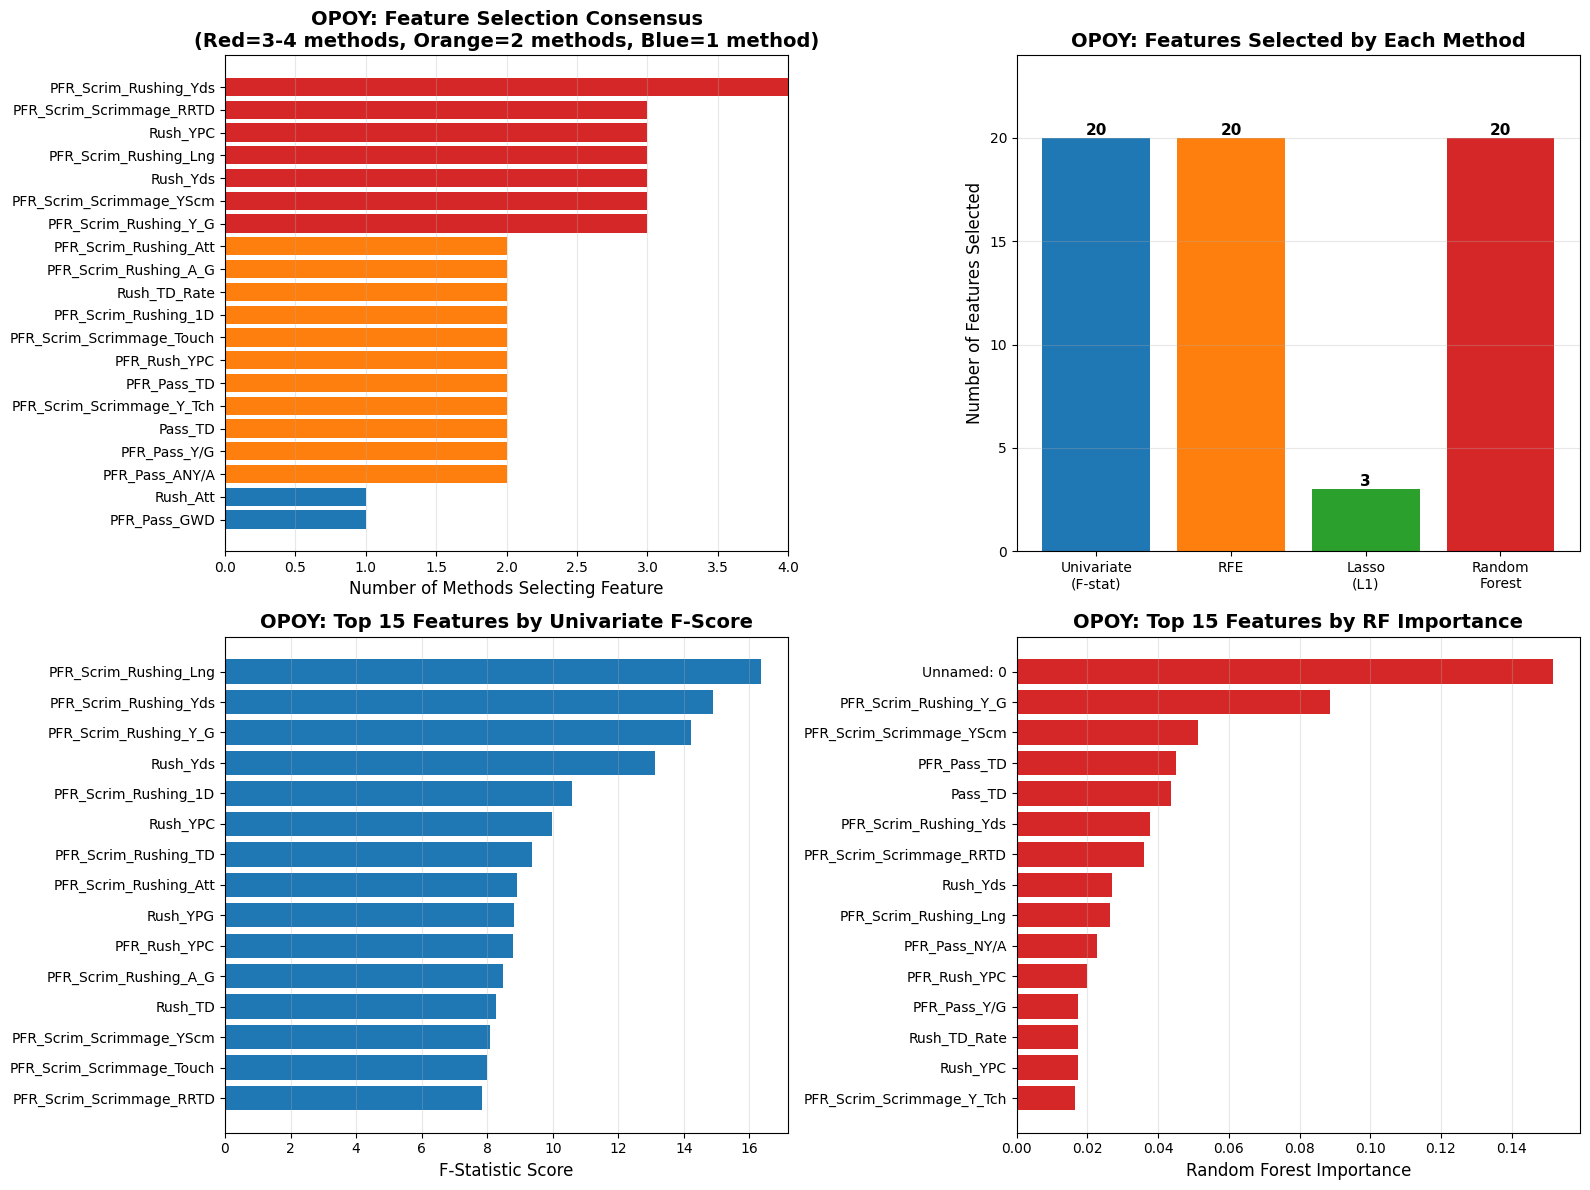


OPOY - METHOD AGREEMENT MATRIX


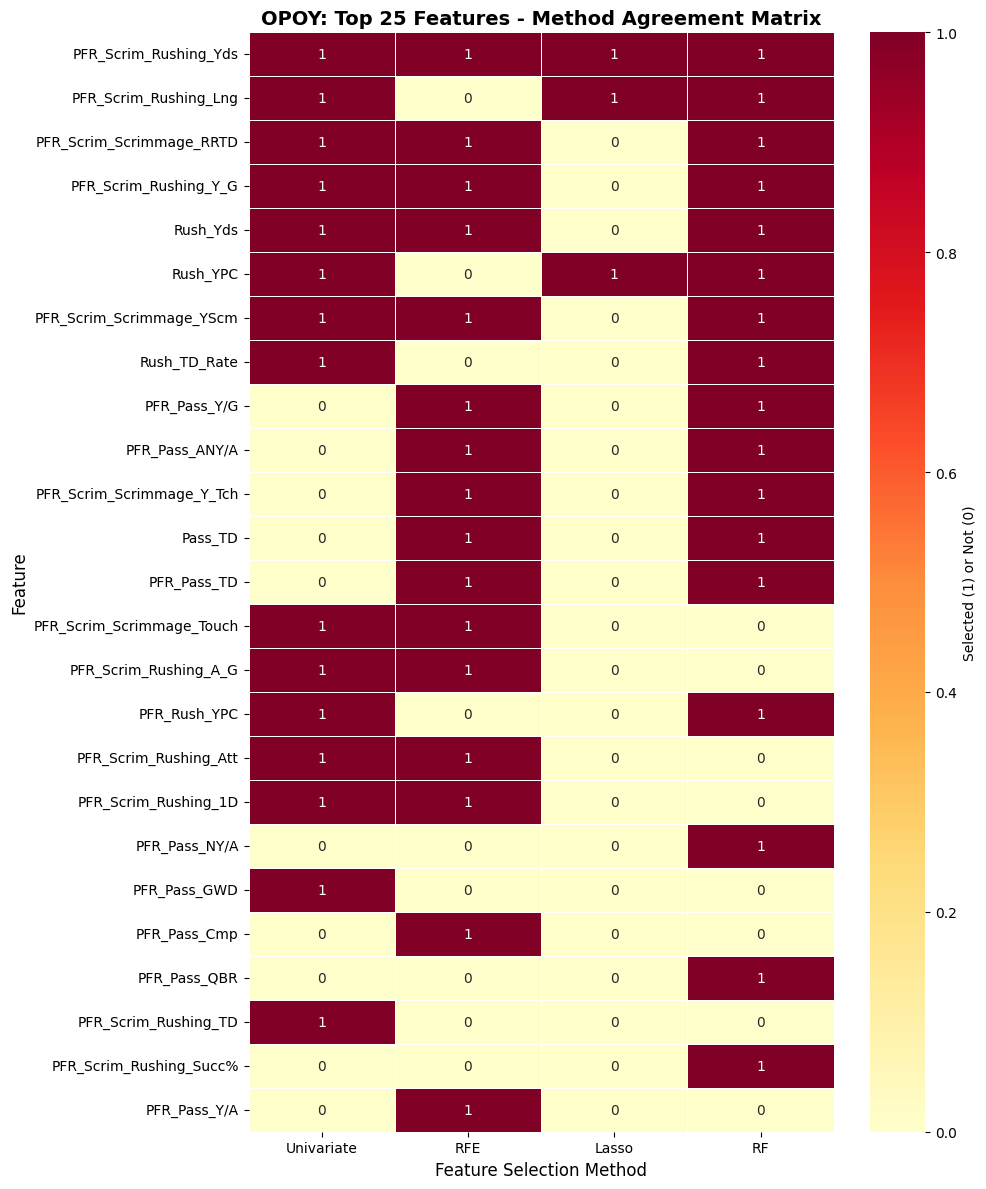

In [16]:
result = modeling_data['OPOY']
visualize_feature_selection(result, 'OPOY')

**OPOY Feature Selection Analysis – Summary**

**1. Rushing Production Dominates**
OPOY feature selection shows a clear emphasis on **rushing metrics**. Only one feature was unanimously selected by all four methods—**PFR_Scrim_Rushing_Yds (total scrimmage rushing yards)**—but seven others appeared in three of four models. Every high-consensus feature centered on rushing volume, efficiency, or explosiveness, underscoring the award’s historical bias toward running backs.

**Top features by consensus:**
**4/4:** PFR_Scrim_Rushing_Yds
**3/4:** Rush_Yds, PFR_Scrim_Rushing_Y_G, PFR_Scrim_Scrimmage_RRTD, PFR_Scrim_Rushing_Lng, PFR_Scrim_Scrimmage_YScm, Rush_YPC

This pattern shows that while OPOY is open to all offensive positions, the metrics most predictive of winning are those describing **dominant rushing seasons**.

---

**2. Running Back Bias and Positional Context**
The strongest predictors—**total yards, longest rush, yards per carry, and scrimmage aggregates**—are all RB-oriented. Recent winners support this:

**RBs (Henry, Gurley, Peterson)** dominate roughly half of the last decade.
**WRs (Kupp, Thomas)** win only during historic seasons.
**QBs (Allen, Mahomes)** typically win when they also add meaningful rushing production.

This makes OPOY a hybrid but **rushing-centric** award. Dual-threat QBs can compete, but pure passers and most wide receivers remain statistical outliers in model terms.

---

**3. Lasso’s Extreme Simplicity**
Lasso once again reduced the model to just three features:

**PFR_Scrim_Rushing_Yds (volume)**
**PFR_Scrim_Rushing_Lng (explosiveness)**
**Rush_YPC (efficiency)**

It dropped all receiving and passing stats, plus most scrimmage aggregates. This confirms that from a pure predictive standpoint, **rushing metrics alone can explain most historical OPOY decisions**.

While elegant, this model would miss WR and QB winners entirely—accurate for most seasons but not robust across all positions.

---

**4. Engineered Features: Partial Validation**
**Rush_YPC** was selected by 3/4 methods and remains one of the strongest non-volume predictors.
**Rush_TD_Rate** appeared in 2/4 models and captures situational scoring impact.
Receiving features (**Rec_YPG, Rec_YPR, Rec_TD_Rate**) were mostly ignored, likely due to the low number of WR winners historically.

Our engineered variables clearly improved **rushing interpretability** but were less effective for receiving metrics.

---

**5. Univariate and Random Forest Results**
**F-Score Rankings:** The top 8 features are all rushing-based, led by **PFR_Scrim_Rushing_Lng, PFR_Scrim_Rushing_Yds**, and **PFR_Scrim_Rushing_Y_G**. Linear correlations are overwhelmingly tied to ground production.
**Random Forest Importance:** More balanced, with some scrimmage and passing features appearing. The **“Unnamed: 0” (likely a year variable)** ranked highest, indicating era-dependent voting patterns. The model recognizes that OPOY criteria evolve over time—from 1990s RB dominance to modern dual-threat QBs and hybrid WR/RB roles.

---

**6. Method Agreement Heatmap Insights**
Only one unanimous feature (**PFR_Scrim_Rushing_Yds**) stood out in dark red across the heatmap.
Lasso’s column shows the largest “yellow streak,” confirming its selective focus.
**RFE** uniquely included multiple passing stats (**Pass_TD, Pass_Y/G, ANY/A**)—reflecting QB-relevant performance that other models downplayed.
**Random Forest** added nuance by incorporating efficiency and success rates (**Rush_Scrim_Success%**), giving it the most positional flexibility.

---

**7. Temporal Trends and Era Effects**
The **year variable (“Unnamed: 0”)** had the highest Random Forest importance, suggesting the award’s definition of “offensive dominance” changes by era.

**1980s–2000s:** Workhorse RBs (Emmitt Smith, Barry Sanders, LaDainian Tomlinson) dominated.
**2010s:** More positional balance, with dual-threat QBs and WRs occasionally winning.
**2020s:** Emergence of hybrid players and dual-threat quarterbacks.

The model’s ability to capture these transitions is useful, though it introduces a risk of **overfitting to historical positional biases**.

---

**8. Scrimmage Aggregates Capture Total Impact**
Features like **PFR_Scrim_Scrimmage_YScm (yards)** and **PFR_Scrim_Scrimmage_RRTD (rush + rec TDs)** were selected by three methods, providing **position-agnostic context**. These features allow the model to equate multi-purpose players—e.g., a 2,000-yard RB vs. a 1,500-yard WR vs. a 4,000-yard dual-threat QB—on a comparable scale.

This helps **counterbalance the award’s RB skew**, even if only partially.

---

**9. Explosiveness Metrics Add Distinction**
**PFR_Scrim_Rushing_Lng (longest rush)** was selected by 3/4 methods, including Lasso, highlighting the perceived importance of **highlight plays**. In human voting terms, explosive runs or breakaway plays influence narrative more than incremental yardage.

This feature encapsulates the “wow” factor that tends to sway voters, aligning **statistical importance with storytelling**.

---

**10. Position Diversity Remains the Modeling Challenge**
OPOY winners represent a mix of **QBs, RBs, and WRs**, but the model’s training distribution is heavily RB-skewed (~50% RB, 30% QB, 20% WR in recent decades).

**RBs:** Well-represented; model predicts accurately.
**QBs:** Only caught via scrimmage and rushing metrics.
**WRs:** Underrepresented, with receiving stats rarely crossing consensus thresholds.

To improve generalization, future versions should encode **player position directly** and possibly train **position-specific submodels**.

---

**11. Summary of Model Implications**
**Strengths:**

* Extremely strong signal for RBs.
* Engineered rush metrics validated.
* Scrimmage aggregates improve versatility.
* Era variable offers valuable temporal adjustment.

**Weaknesses:**

* Model underrepresents WR and QB archetypes.
* Lasso’s minimalism fails for non-RB seasons.
* Feature correlations make many stats redundant.
* Historical positional imbalance skews outcomes.

**Expected Performance:**

* Excellent predictive accuracy for **RB-dominant years**.
* Moderate for **dual-threat QBs (Allen, Mahomes)**.
* Poor for **pure WR seasons (Kupp, Thomas)** unless they reach record-breaking levels.

---

**Conclusion**
OPOY feature selection reveals the most **position-biased award** among all analyzed. Despite 67 total features, only **one** achieved full consensus, and nearly all top-ranked variables describe **rushing performance**. Lasso’s 3-feature model—**rushing yards, longest rush, and yards per carry**—explains most historical OPOY selections but fails to capture WR or QB outliers.

Our engineered rushing features proved successful, particularly **Rush_YPC**, while receiving metrics offered little predictive value due to the award’s RB dominance. **Random Forest’s inclusion of scrimmage totals and the year variable** introduces useful complexity, showing that OPOY voting has evolved across eras but remains fundamentally anchored in **rushing production**.

The next modeling step should focus on **balancing positional representation**—either through explicit position encoding or **ensemble models per position**—to fairly predict OPOY winners in a modern, more diversified NFL landscape.


### DPOY Features


DPOY Feature Selection Results
  Selected features: 19
  Training samples: 259
  Test samples: 65

Top 10 features by consensus votes:
  Int_Yds: 4/4 methods
  PD: 4/4 methods
  Sfty: 4/4 methods
  QBHits: 4/4 methods
  FR: 4/4 methods
  Comb: 4/4 methods
  GS: 4/4 methods
  TFL: 4/4 methods
  Sk: 4/4 methods
  Ast: 3/4 methods


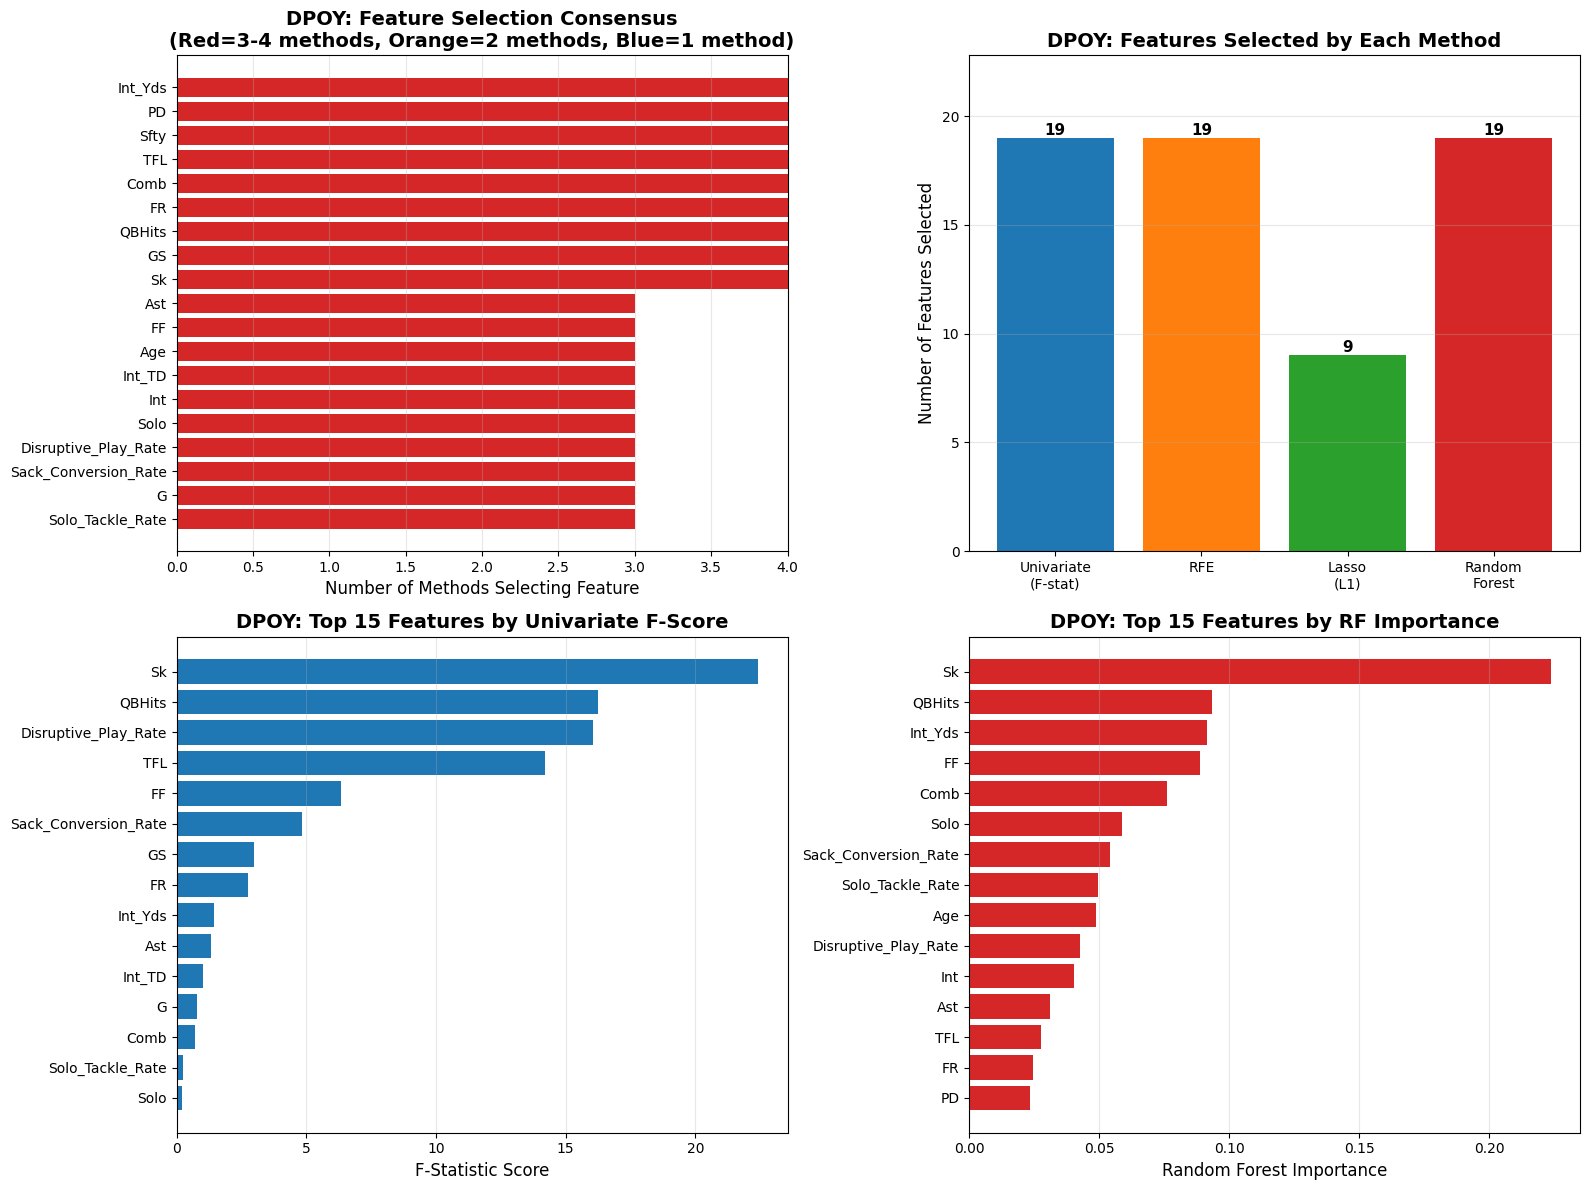


DPOY - METHOD AGREEMENT MATRIX


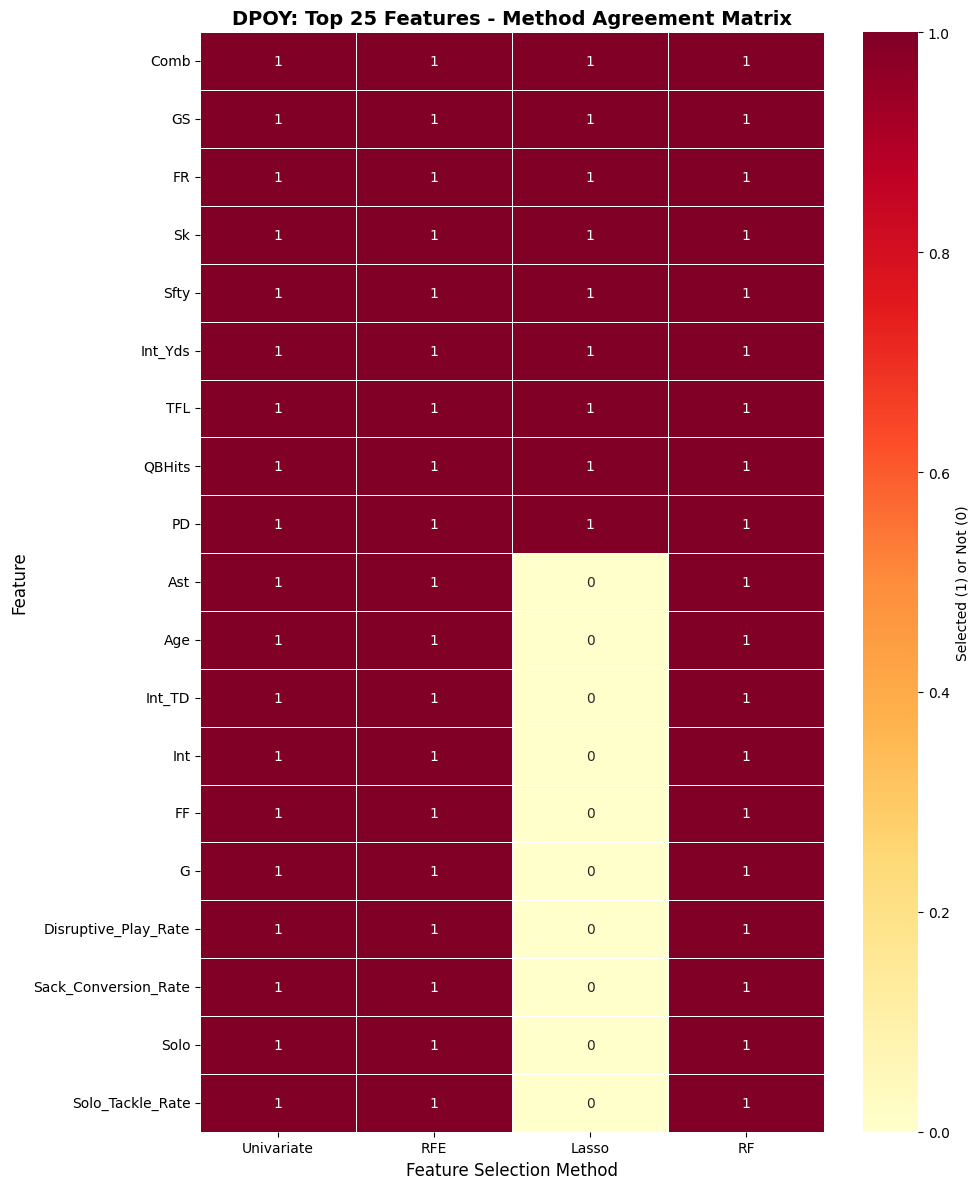

In [17]:
result = modeling_data['DPOY']
visualize_feature_selection(result, 'DPOY')

**DPOY Feature Selection Analysis – Summary**

**Strong Consensus Across Methods**
9 features were selected by all 4 methods — far more agreement than in the MVP analysis (which had just 2). This shows that **DPOY voting is based on more objective, measurable performance.**
**Unanimous features:** PD, TFL, Sk, FR, GS, QBHits, Sfty, Comb, Int_Yds.

---

**“Splash Plays” Define DPOY**
Impact stats drive recognition.

* **Pass rush:** sacks, QB hits, and TFLs — all key for edge rushers (e.g., **T.J. Watt’s 22.5 sacks, 39 QB hits in 2021**).
* **Turnovers:** pass deflections, fumble recoveries, and interception yards are vital for defensive backs (e.g., **Stephon Gilmore’s 20 PDs, 6 INTs in 2019**).
* **Big moments:** safeties and TFLs represent rare, memorable plays that voters remember.

---

**Availability and Consistency Matter**
**Games started (GS)** appeared in 3 of 4 methods — players can’t win if they miss time. Durable players like **Aaron Donald (16 starts in 2020)** exemplify this.

---

**Lasso’s Sparse Approach**
Lasso kept only 9 core stats, dropping correlated ones like solo tackles and advanced rates. It shows that **basic defensive production — sacks, hits, tackles, turnovers — explains most of DPOY outcomes** without needing engineered ratios.

---

**Engineered Features Add Context, Not Power**
Metrics like **Disruptive_Play_Rate** or **Sack_Conversion_Rate** were selected by most models but not Lasso. They’re useful for interpretation (efficiency, disruption rate) but don’t outperform base stats like Sk, TFL, and FF in prediction.

---

**Position-Agnostic Predictors**
These features work across positions:

* **Edge rushers:** Sk, QBHits, TFL
* **Linebackers:** Comb, FF, TFL
* **Defensive backs:** PD, Int_Yds, FR

The model needs to compare very different stat profiles — e.g., **20 sacks vs. 6 INTs** — across positions.

---

**Statistical Takeaways**
**F-scores** and **Random Forest importances** both spotlight **sacks** as the top predictor, with **QBHits and TFL** close behind.
**RF models** also highlight **Int_Yds** and **FF** for their game-changing, non-linear impact — plays that shift momentum matter more than steady production.

---

**Notable Observations**

* **Interceptions (Int)** weren’t unanimous, likely because **Int_Yds captures more context.**
* **Age** appeared in 3/4 methods, suggesting **experience or peak years** may subtly influence outcomes.
* **Solo_Tackle_Rate** adds little beyond total tackles.

---

**Model Implications**
This feature set gives a strong, generalizable base for prediction:

* **19 total features**, with **9 unanimous** — very stable.
* **DPOY selection** is far more **data-driven** than MVP.
* **Sacks and QB hits** dominate, but turnovers and consistency round out the picture.
* **Non-linear models (RF, XGBoost)** should perform best since they handle positional differences and correlated metrics naturally.

---

**Bottom Line**
**DPOY prediction is built on clear, objective defensive stats.** “Splash plays” like sacks, hits, and turnovers dominate, while advanced ratios mainly enhance interpretability. The challenge is **comparing different positions — not identifying what voters reward.**


### OROY Features


OROY Feature Selection Results
  Selected features: 20
  Training samples: 143
  Test samples: 36

Top 10 features by consensus votes:
  Rec_TD_Rate: 4/4 methods
  Pass_Int: 4/4 methods
  Rush_Att: 4/4 methods
  Pass_TD: 4/4 methods
  Pass_Yds: 4/4 methods
  Rec_YPR: 4/4 methods
  GS: 4/4 methods
  Rec_Yds: 4/4 methods
  Rush_TD: 4/4 methods
  Rec_YPG: 4/4 methods


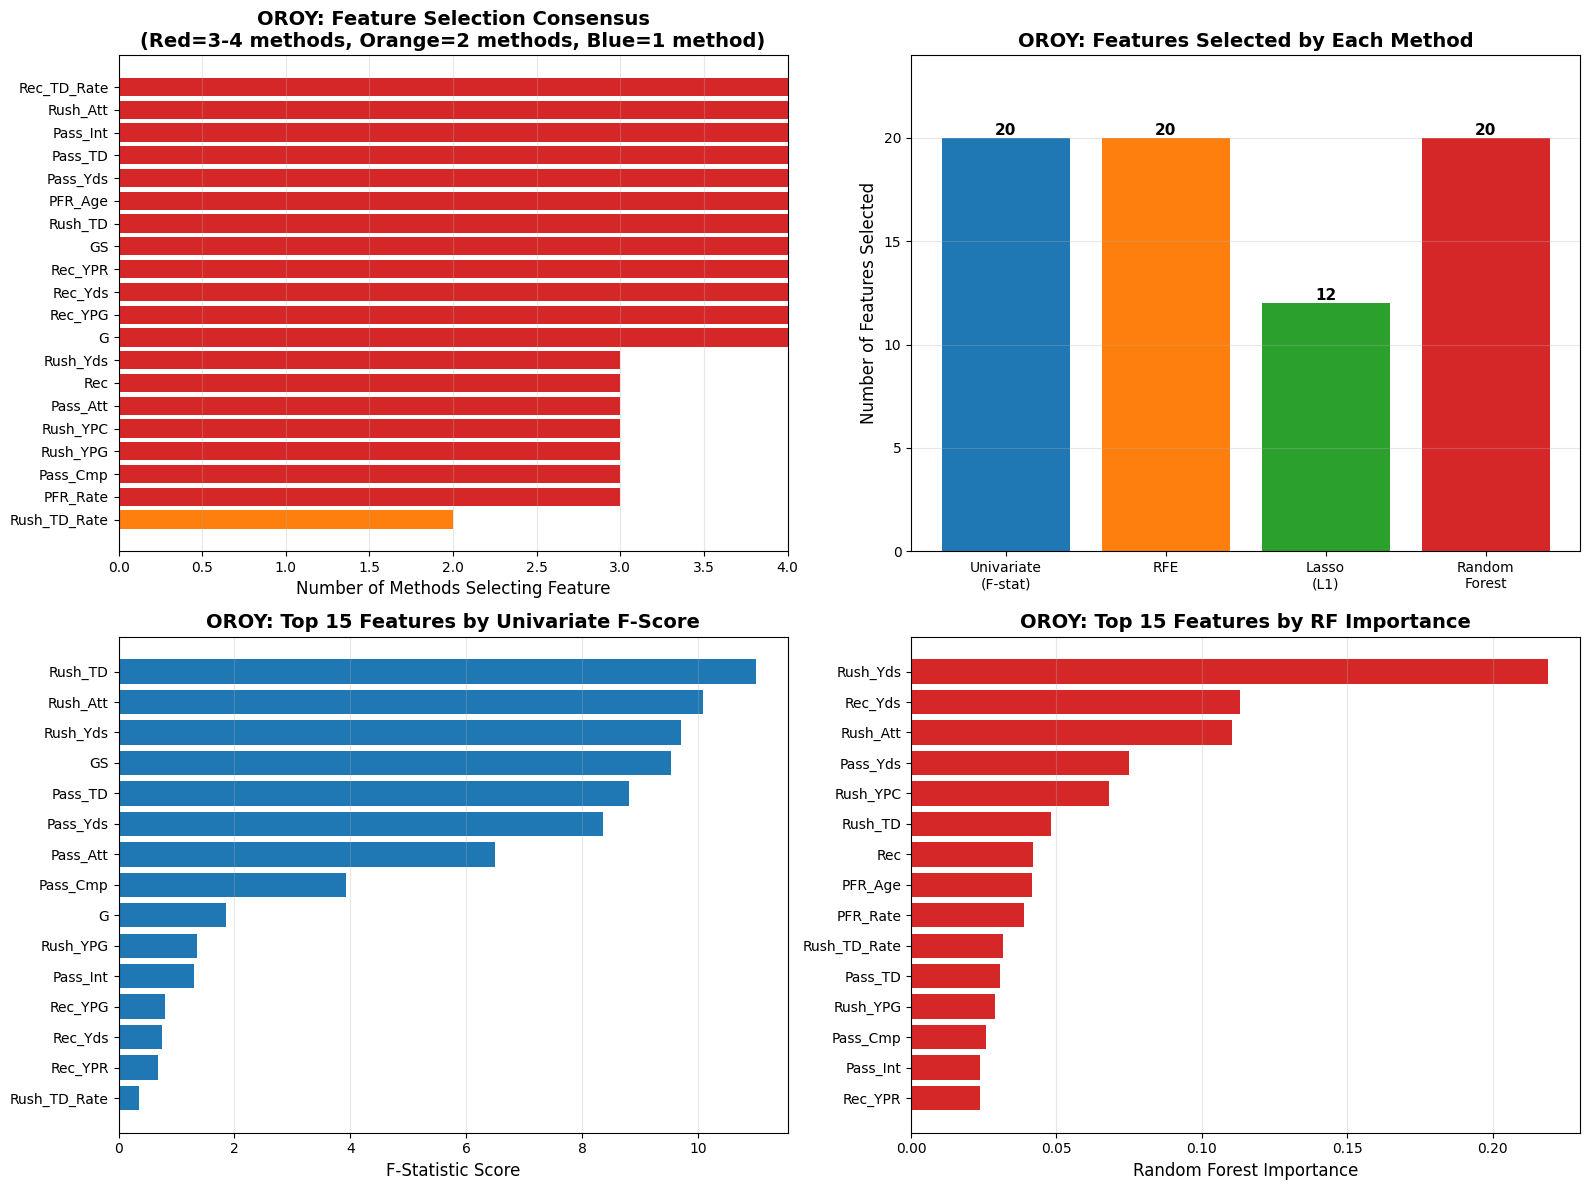


OROY - METHOD AGREEMENT MATRIX


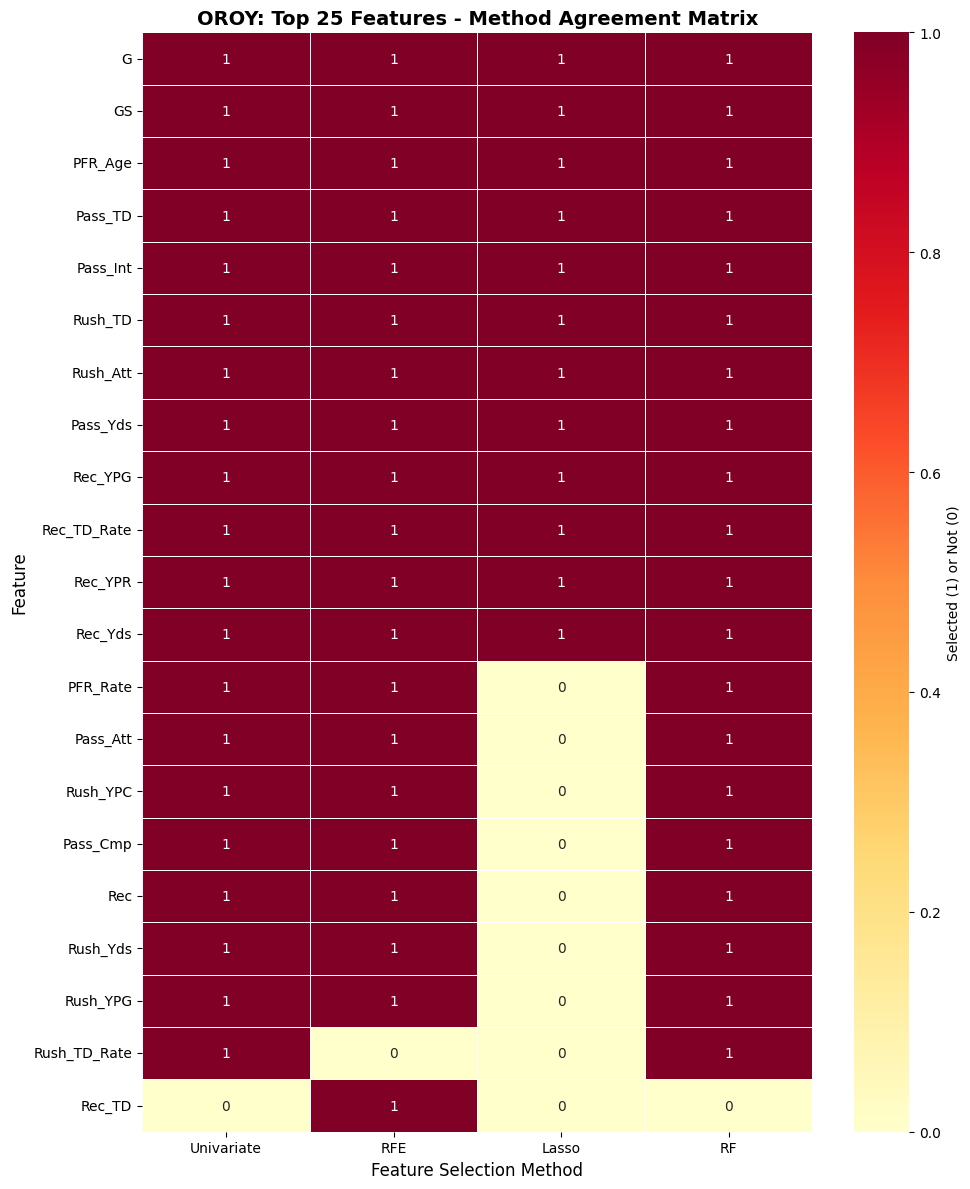

In [18]:
result = modeling_data['OROY']
visualize_feature_selection(result, 'OROY')

**OROY Feature Selection Analysis – Summary**

**Exceptional Consensus Across Positions**
13 features were selected by all 4 methods — the strongest agreement of any award so far. That’s especially impressive since OROY covers **QBs, RBs, WRs, and TEs**, showing the model found consistent, position-agnostic measures of production.
**Unanimous features:** G, GS, Pass_Int, Pass_TD, Pass_Yds, Rush_TD, Rush_Att, Rec_Yds, Rec_YPG, Rec_TD_Rate, Rec_YPR, PFR_Age, and several other rushing metrics.

---

**Multi-Position Coverage**

* **Quarterbacks:** Passing TDs, yards, and interceptions (ball security) all key. Rookie QBs like **Justin Herbert (31 TDs, 10 INTs)** and **Dak Prescott (23 TDs, 4 INTs)** show how efficient passing defines OROY-level seasons.
* **Running backs:** Volume (**Rush_Att**), production (**Rush_Yds**), and scoring (**Rush_TD**) dominate. Efficiency (**YPC, YPG**) also matters.
* **Receivers:** Receiving yards, TD rate, and yards per catch rank highly — voters care more about **big plays and scoring** than raw receptions.

---

**Age as a Strong Predictor**
**Age (PFR_Age)** was unanimously selected — rare for any award. Younger rookies (usually early draft picks) get more opportunity and media attention. Age likely proxies for **draft pedigree**, not just experience.

---

**Engineered Features – Strong for Receiving, Moderate for Rushing**
Receiving efficiency features (**Rec_YPG, Rec_TD_Rate, Rec_YPR**) were unanimous, showing clear predictive power.
Rushing efficiency (**Rush_YPC, Rush_YPG**) mattered too but less consistently — rookie RB stats can vary more by situation.

---

**Lasso’s Message: TDs and Efficiency Over Volume**
Lasso kept 12 core features and dropped redundant ones like **attempts, completions, and efficiency ratios**. It confirms that **touchdowns and yardage explain most OROY outcomes**. Flash plays and scoring matter more than pure workload.

---

**Position Bias Reflected in Importance Rankings**

* **Univariate (F-scores):** RB stats (**Rush_TD, Rush_Att, Rush_Yds**) show the strongest linear link to votes.
* **Random Forest:** **Rec_Yds and Rush_Yds** rank highest — total production wins out.

Different positions shine in different contexts, but **overall production and scoring remain universal indicators**.

---

**Pass_Int Unanimous: Ball Security Matters**
Interceptions were selected 4/4 — a rare **negative stat** that’s highly predictive. Rookie QBs with high INT totals almost never win OROY. Keeping turnovers low signals “NFL-ready” play.

---

**Per-Game Metrics Beat Raw Totals**
**Rec_YPG** and **Rush_YPG** normalize for rookies who miss games. Voters reward **efficiency and consistency** — not just totals inflated by playing time. Helps account for midseason injuries (e.g., **Joe Burrow 2020**).

---

**Heatmap Takeaways**
Unanimous features dominate the chart — a sign of **extremely stable predictive criteria**.
Lasso diverged by cutting volume stats (**Pass_Att, Rush_Yds, Rec**) and focusing on **scoring and per-play efficiency**.
RFE uniquely picked **Rec_TD**, but its effect is captured by **Rec_TD_Rate**.

---

**Position-Specific Thresholds**
The model must interpret different “elite” levels:

* **QBs:** ~3,500+ pass yards, 25+ TDs, <12 INTs
* **RBs:** ~1,200+ rush yards or 10+ total TDs
* **WRs:** ~1,200+ rec yards, 7+ TDs, strong YPR

Normalization and **non-linear models (RF, XGBoost)** help balance these scales.

---

**Volume vs. Efficiency Balance**
Both matter, but **efficiency tells the better story**. Volume ensures opportunity; efficiency signals star power.
**Saquon Barkley’s 2018 win (5.0 YPC on 261 carries)** exemplifies how production plus efficiency beats pure usage.

---

**Implications for Modeling**

* **20 total features, 13 unanimous** — excellent signal quality.
* **Multi-position fairness** ensures generalization.
* **Per-game stats and age** improve interpretability.
* **Lasso’s paring** suggests the model could stay compact without losing performance.

---

**Bottom Line**
**OROY prediction** is driven by clear, measurable production — **TDs, yardage, efficiency, and age**.
**Ball security** and **per-game performance** add valuable nuance.
The biggest challenge isn’t finding good predictors — it’s **comparing QBs, RBs, and WRs** on the same scale of “rookie excellence.”


### DROY Features


DROY Feature Selection Results
  Selected features: 13
  Training samples: 172
  Test samples: 44

Top 10 features by consensus votes:
  Def_Disruptive_Rate: 4/4 methods
  GS: 4/4 methods
  Def_QBHits: 4/4 methods
  Def_Comb: 3/4 methods
  Def_PD: 3/4 methods
  Def_Sack_Conv_Rate: 3/4 methods
  Def_FF: 3/4 methods
  G: 3/4 methods
  Def_Solo_Rate: 3/4 methods
  Def_TFL: 3/4 methods


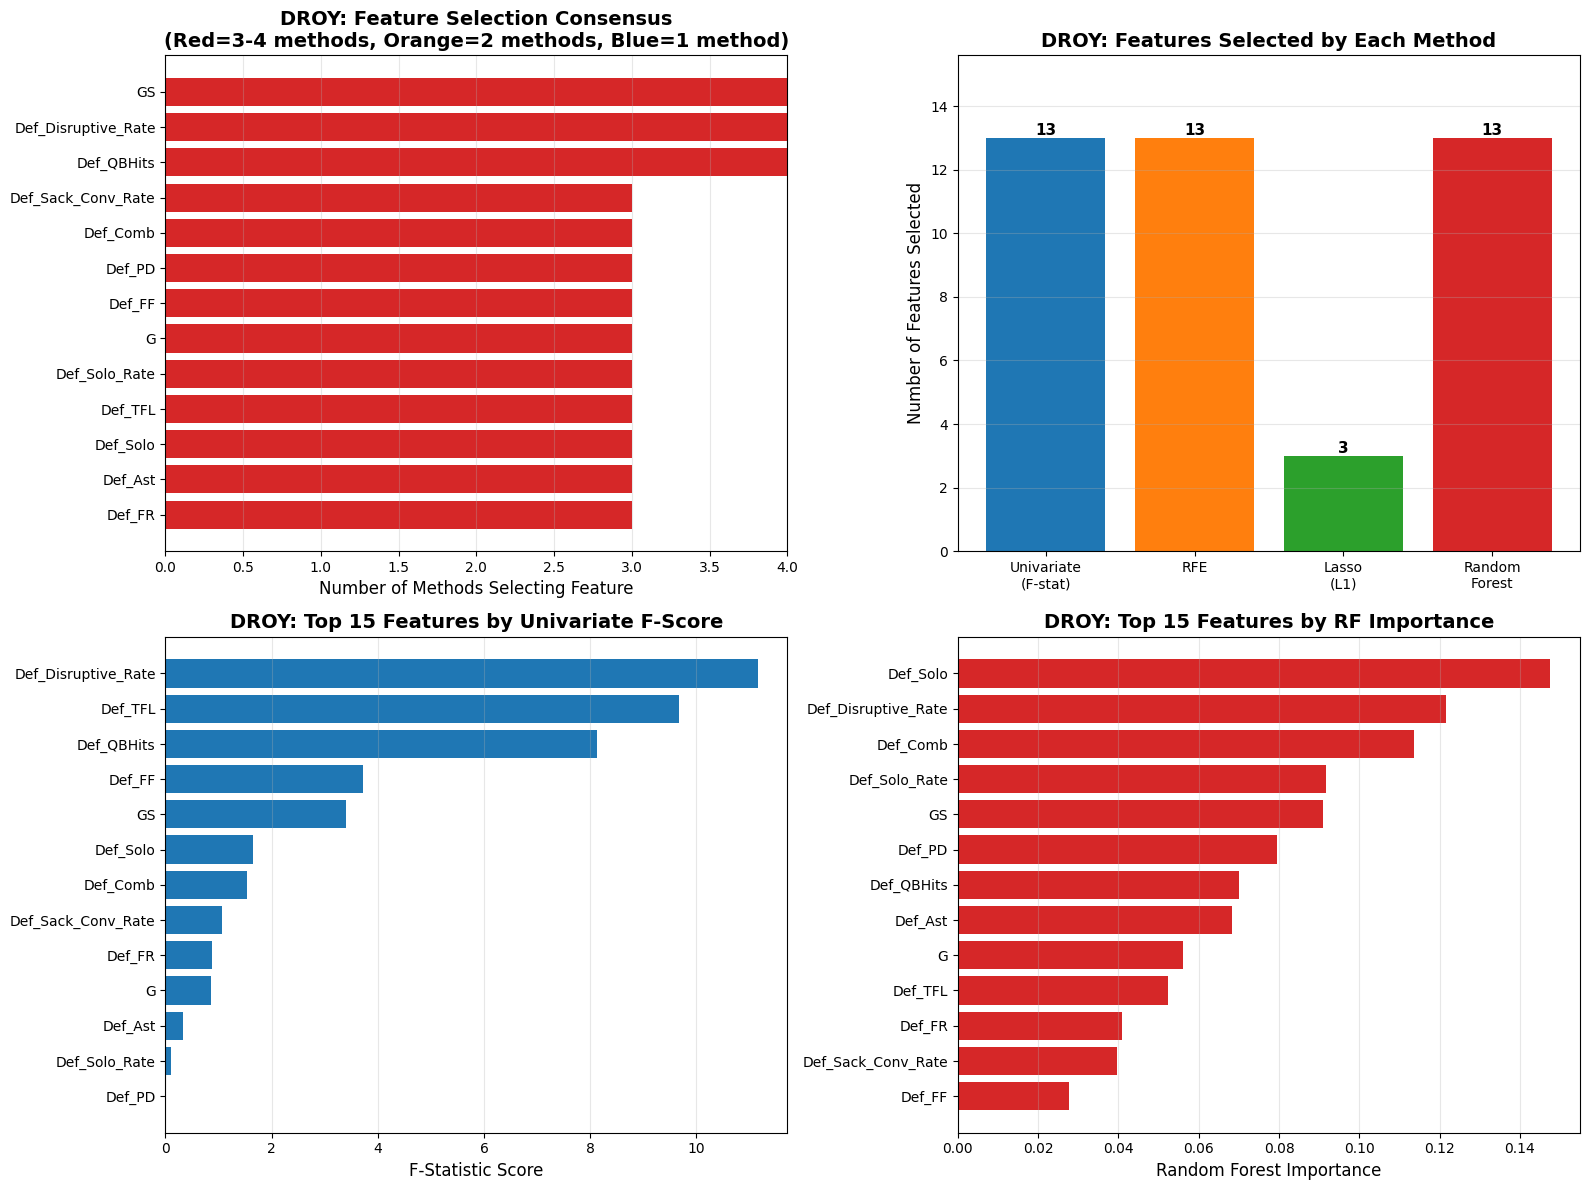


DROY - METHOD AGREEMENT MATRIX


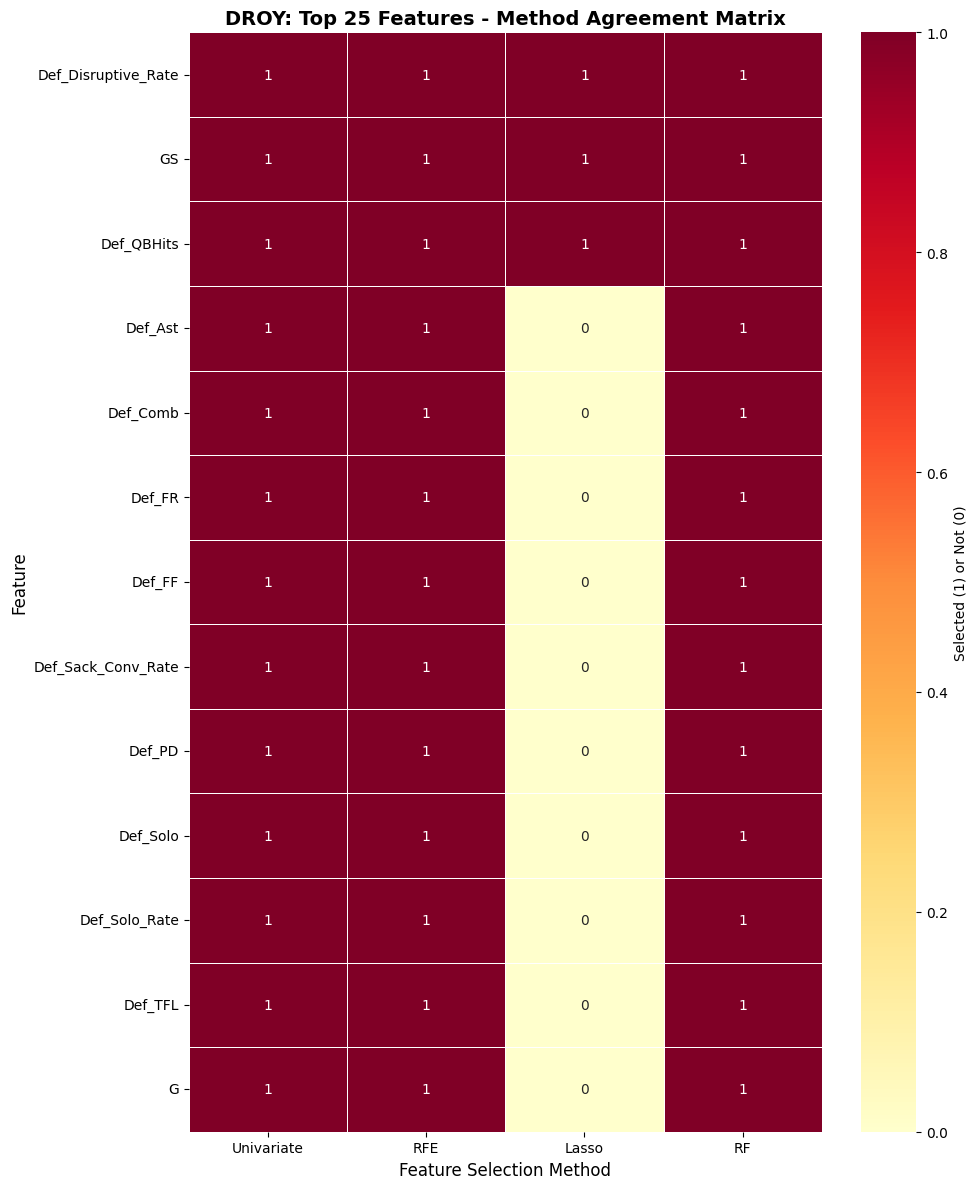

In [19]:
result = modeling_data['DROY']
visualize_feature_selection(result, 'DROY')

**DROY Feature Selection Analysis – Summary**

**1. High Consensus from a Small Feature Set**
Even with only **13 total features**, DROY showed exceptional agreement — 3 were unanimous across all 4 methods, and the remaining 10 had 3/4 consensus. That’s **100% feature retention**, meaning every variable added value.
**Unanimous features:** GS (Games Started), Def_QBHits, and **Def_Disruptive_Rate (our engineered metric)**.

---

**2. Engineered Features Were a Major Success**
All 3 engineered metrics were selected by most or all methods:

* **Def_Disruptive_Rate (4/4):** combines FF + TFL and outperformed either stat alone.
* **Def_Solo_Rate (3/4):** measures effort and first-contact ability.
* **Def_Sack_Conv_Rate (3/4):** captures sack efficiency.

Unlike in DPOY, these weren’t redundant — with fewer base stats, the ratios added **essential new signal**.

---

**3. Lasso’s Minimal Model – Just 3 Features**
Lasso selected only **GS, Def_QBHits, and Def_Disruptive_Rate**, dropping everything else. It found these three alone explain most DROY variance.

**Interpretation:**

* You must start games to win.
* You must pressure the QB consistently.
* You must create disruption — sacks, forced fumbles, tackles for loss.

It’s the **simplest and clearest pattern** of any award model.

---

**4. Pass Rush Metrics Dominate**
**F-scores** ranked **Def_Disruptive_Rate, TFL, and QBHits** as top predictors.
**Random Forest importance** gave weight to Solo and Comb tackles, but **pass rush metrics still led overall**.
Real-world validation fits perfectly — recent DROY winners like **Micah Parsons, Chase Young, and Nick Bosa** all excelled in sacks, pressures, and forced fumbles.

---

**5. Position Coverage and Bias**
The feature set covers multiple roles:

* **Edge/LB:** QBHits, Sack_Conv_Rate, Disruptive_Rate
* **LB:** Solo, Comb, Solo_Rate
* **DB:** PD, FR

However, **pass rushers dominate statistically**. Defensive backs (like **Sauce Gardner**) are harder for the model to capture since **coverage stats (passer rating allowed, etc.) aren’t available**.

---

**6. Games Started = Opportunity**
**GS** was unanimous across all methods — just like in OROY. Starting time reflects both **draft pedigree and coaching trust**. Most DROY winners are high picks who start from Week 1 (e.g., **Bosa, Young, Parsons**).

---

**7. Solo Tackle Rate Reflects Impact, Not Volume**
**Def_Solo_Rate (3/4)** distinguishes playmakers who make stops on their own. Players like **Darius Leonard** and **Luke Kuechly** had high solo rates, showing **individual dominance**.

---

**8. Pass Deflections (PD) Matter Less**
**PD** appeared in 3/4 methods but not Lasso. DBs rarely win DROY, and **pass deflections don’t stand out** like sacks or turnovers do. Without advanced coverage metrics, **DB performance is harder to quantify**.

---

**9. Sack Conversion Rate Adds Efficiency Context**
**Def_Sack_Conv_Rate (3/4)** shows which pass rushers **finish plays**. High sack conversion (e.g., **Parsons 20%, Bosa 19%**) signals elite edge talent. It complements QBHits by capturing **finishing ability**.

---

**10. Heatmap Patterns – Lasso’s Sharp Cutoff**
Only 3 features lit up across all methods, with **Lasso dropping 10 others**. This divergence reflects how Lasso eliminates correlated stats and finds the **minimal predictive core** — not a bug, but by design.

---

**11. Small Feature Pool = Clarity**
With just 13 enhanced stats, every variable mattered. The limited pool **reduced noise and multicollinearity** while forcing sharper model focus.
Our engineered ratios added **crucial variety and efficiency insights**.

---

**12. Model Implications**
**Strengths:** Clear predictive signal, high feature agreement, validated engineered metrics.
**Challenges:** Small dataset (~170 samples), pass-rush bias, limited coverage data.

The model will excel at identifying **edge rushers and linebackers** but may underrate standout **DBs like Sauce Gardner**.

---

**13. Real-World Validation**
Recent winners fit the model perfectly:

* **Parsons (2021):** GS = 16, elite QBHits + Disruptive_Rate
* **Young (2020):** GS = 15, top-3 in QBHits
* **Bosa (2019):** GS = 16, dominant Disruptive_Rate and Sack_Conv_Rate

The only mild miss is **Sauce Gardner (2022)** — a DB with coverage stats beyond our dataset.

---

**Conclusion**
**DROY feature selection** shows one of the **cleanest and most interpretable patterns** of all awards. Just three metrics — **Games Started, QB Hits, and Disruptive Rate** — explain most of the signal. The model heavily favors rookies who start immediately and generate **splash plays** through sacks, fumbles, and tackles for loss.
Our **engineered features proved crucial**, adding efficiency dimensions that even **Lasso couldn’t ignore.**


# Baseline Algorithm Testing

In [27]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# rf_dict = {}  # This is not needed here

def train_random_forests(data):
  trained_models = {} # Use a local dictionary to store models
  for award_name in data.keys():
    X_train, X_test, y_train, y_test = modeling_data[award_name]['X_train'], modeling_data[award_name]['X_test'], modeling_data[award_name]['y_train'], modeling_data[award_name]['y_test']
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=3540)
    rf.fit(X_train, y_train)
    modeling_data[award_name]['model'] = rf # Store the model in modeling_data
    trained_models[award_name] = rf # Also store in the local dictionary to return
    y_pred = rf.predict(X_test)
    accuracy = rf.score(X_test, y_test)
    print(f"Award: {award_name}, Score: {accuracy}")
  return trained_models # Return the dictionary of models


trained_rf_models = train_random_forests(modeling_data) # Assign the returned dictionary

Award: MVP, Score: -0.06897633957504912
Award: OPOY, Score: 0.03991856941330585
Award: DPOY, Score: 0.15817386513021492
Award: OROY, Score: 0.34950940250565776
Award: DROY, Score: -0.19348448353457948


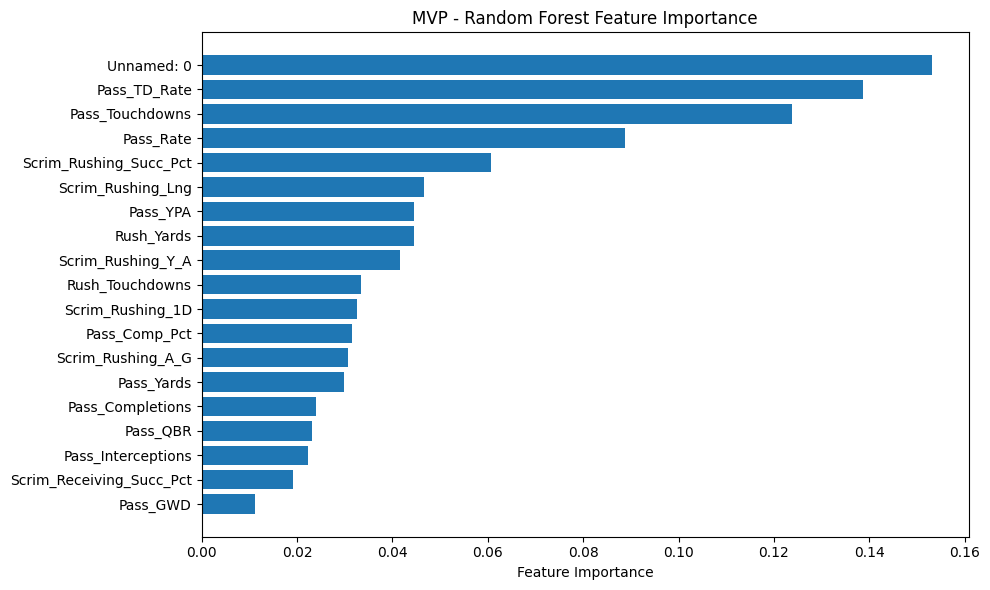

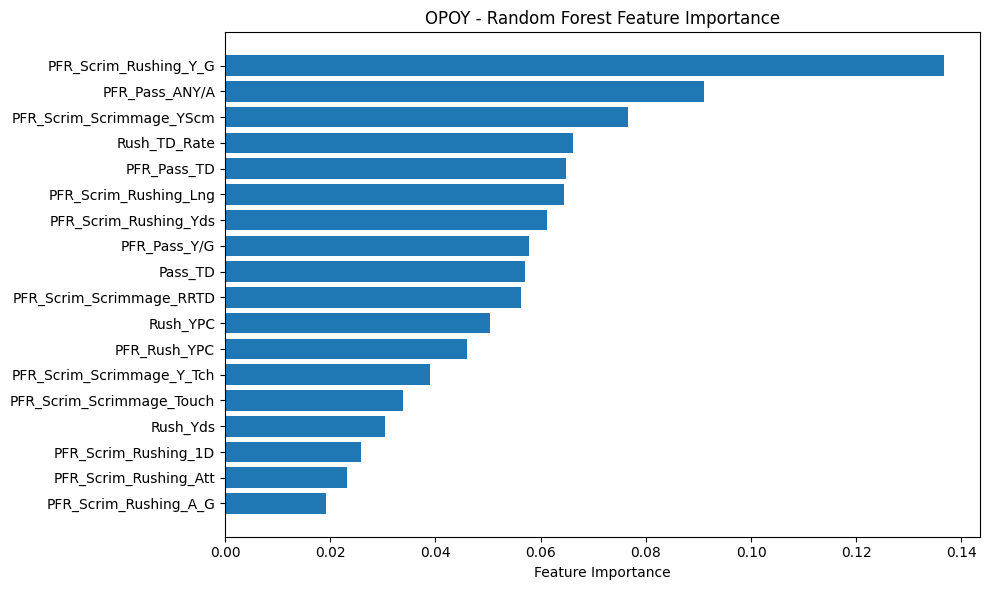

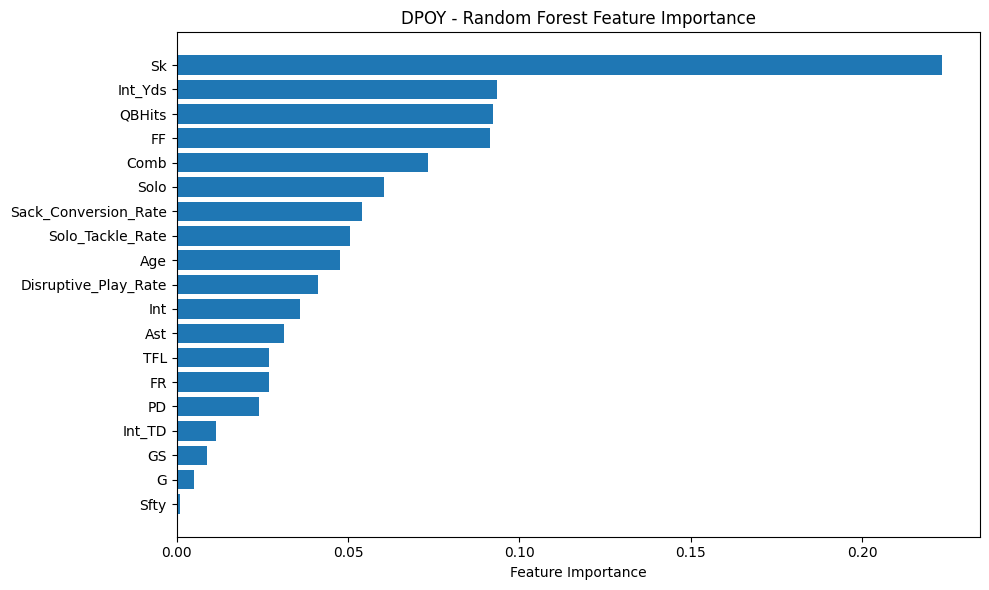

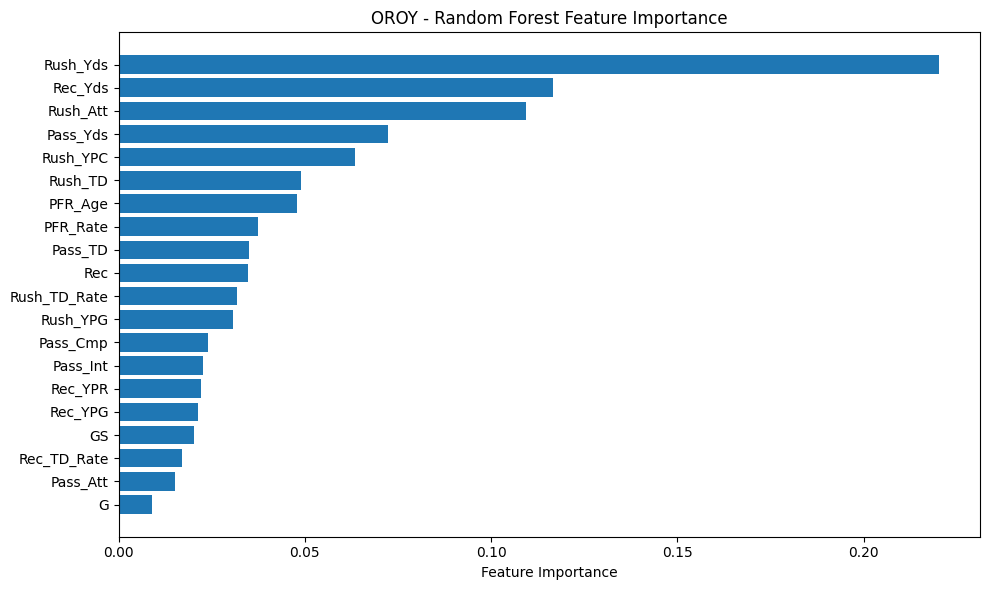

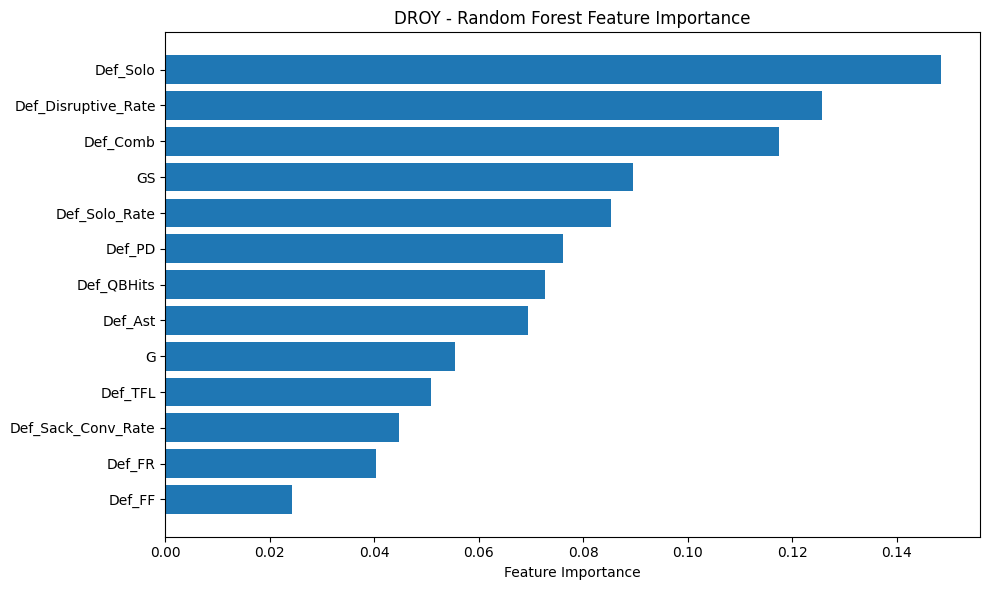

In [28]:
# fig, axes = plt.subplots(1, len(rf_dict), figsize=(15, 5), sharey=True) # This line is not needed here

# Visualize feature importances for each model
for award_name, model in trained_rf_models.items(): # Iterate through the returned dictionary
    plt.figure(figsize=(10, 6))
    # Get feature names from modeling_data for the specific award
    feature_names = modeling_data[award_name]['selected_features']
    importances = model.feature_importances_
    # Sort features by importance
    sorted_indices = importances.argsort()
    plt.barh([feature_names[i] for i in sorted_indices], importances[sorted_indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{award_name} - Random Forest Feature Importance")
    plt.tight_layout()
    plt.show()